In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cpi
import json
import numpy as np
import pandas as pd
import scipy
import os
import pickle
import re
import seaborn as sns

from dateutil.parser import parse
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
import plotly.express as px
import plotly.graph_objs as go

# Data loading

## Load CMU Movie Summary Corpus dataset

In [4]:
#Load characters metadata
names = ['Wikipedia movie ID','Freebase movie ID','Movie release date','Character name','Actor date of birth','Actor gender','Actor height (in meters)','Actor ethnicity (Freebase ID)','Actor name','Actor age at movie release','Freebase character/actor map ID','Freebase character ID','Freebase actor ID']
characters = pd.read_csv("./data/MovieSummaries/character.metadata.tsv", sep='\t', header=None, names=names).drop(columns = ["Movie release date"])

# store the release date as datetime objects
characters["Actor date of birth"] = characters["Actor date of birth"].apply(lambda x: parse(x) if not pd.isna(x) else pd.NaT)

# Convert data types to integers for specific columns
columns = ["Actor age at movie release"]
for column in columns:
  characters[column] = characters[column].astype("Int64")

characters.head()

,Wikipedia movie ID,Freebase movie ID,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,Akooshay,1958-08-26 00:00:00,F,1.620,NaN,Wanda De Jesus,42,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15 00:00:00,F,1.780,/m/044038p,Natasha Henstridge,27,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,Desolation Williams,1969-06-15 00:00:00,M,1.727,/m/0x67,Ice Cube,32,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12 00:00:00,M,1.750,NaN,Jason Statham,33,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25 00:00:00,F,1.650,NaN,Clea DuVall,23,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [5]:
#Load movies metadata
names = ['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date','Movie box office revenue','Movie runtime','Movie languages','Movie countries','Movie genres']
movies = pd.read_csv("./data/MovieSummaries/movie.metadata.tsv", sep='\t', header=None, names=names)

# correct manualy the mistake in the date 1010-12-02 to 2010-12-02 on index 62836
movies.loc[62836, "Movie release date"] = "2010-12-02"

# store the release date as datetime objects
movies["Movie release date"] = movies["Movie release date"].apply(lambda x: parse(x) if not pd.isna(x) else pd.NaT)

# populate a column with only the year in numerical format
movies["Movie release year"] = movies["Movie release date"].dt.year

# Convert data types to integers for specific columns
columns = ["Movie release year","Movie release year"]
for column in columns:
  movies[column] = movies[column].astype("Int64")

movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000
2,28463795,/m/0crgdbh,Brun bitter,1988-12-22,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988
3,9363483,/m/0285_cd,White Of The Eye,1987-12-22,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987
4,261236,/m/01mrr1,A Woman in Flames,1983-12-22,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983


### Adjust Box office revenues

First, let's plot the box office revenues of the movie over the years to have an overview of the data distribution.

/tmp/ipykernel_2058/2462572862.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f"{np.exp(tick):.0e} $" for tick in ticks])


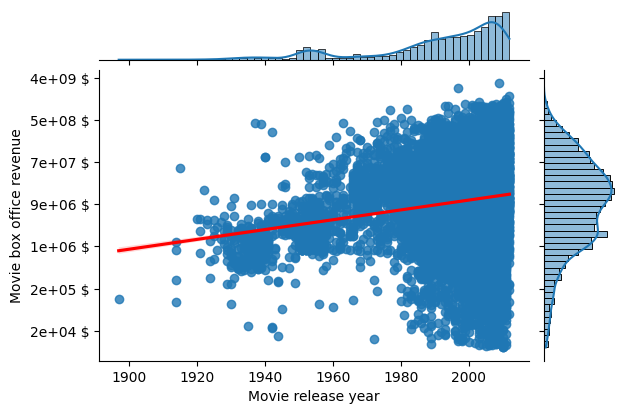

In [6]:
# remove the nans in for a subset of the movies dataframe
movies_subset = movies.dropna(subset=['Movie release year', 'Movie box office revenue']).copy(deep=True)

# convert the year to float and take the log of the revenue
movies_subset['Movie release year'] = movies_subset['Movie release year'].astype(float)
movies_subset['Movie box office revenue'] = np.log(movies_subset['Movie box office revenue'])

# plot the data with a linear regression
grid = sns.jointplot(data=movies_subset,x="Movie release year", y="Movie box office revenue", kind="reg", line_kws={'color': 'red'})
grid.fig.set_figwidth(6)
grid.fig.set_figheight(4)

# Get current y-ticks and convert them back to original scale
ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels([f"{np.exp(tick):.0e} $" for tick in ticks])

plt.show()

From the plot, we can see that the movie revenues over the years follow an exponential distribution. In fact, the average box office revenue per film is increasing exponentially over the years, hence the positive slope of the linear regression of the data points. This is due to the compounding effect of monetary inflation year over year. We can take account of this and adjust the revenues in usd using inflation data given by the US Consumer price index (CPI).

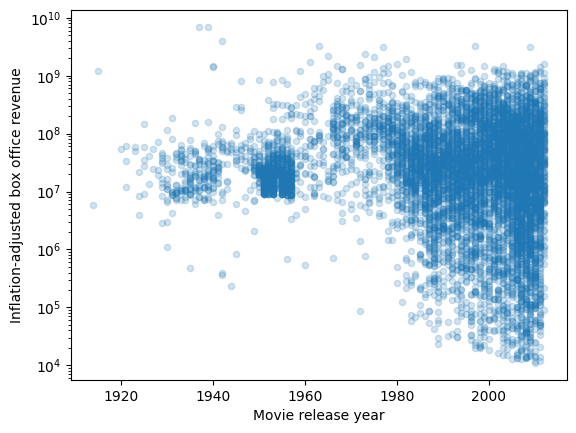

In [7]:
# Take the latest available year of the dataset as reference
max_year = movies["Movie release year"].max()

# Update CPI data
cpi.update()

# Adjust dollars revenues for inflation
movies["Inflation-adjusted box office revenue"] = movies.dropna().apply(lambda row: cpi.inflate(row["Movie box office revenue"], row["Movie release year"], to=max_year),axis=1)

# remove the nans in for a subset of the movies dataframe
movies_subset = movies.dropna(subset=['Movie release year', 'Inflation-adjusted box office revenue']).copy(deep=True)

# convert the year to float
movies_subset['Movie release year'] = movies_subset['Movie release year'].astype(float)

# Plot the newly generated Inflation-adjusted revenues
movies_subset.plot(x="Movie release year", y="Inflation-adjusted box office revenue", kind="scatter", alpha=0.2)
plt.yscale('log')

plt.show()

Although other effects can affect the revenue distribution over the years, the resulting plot shows a more uniform trend than the previous one



It is worth noting that the number of available data for box office revenues is not evenly distributed across the years. This is because most of the films from the CMU Movie dataset have missing box office revenues informations. The following plot shows the percentage of films with missing revenues over the years. Although, the percentage of missing values is quite large overall, a relevant analysis on the box office revenues will be possible because the remaining films with valid financial performances is quite large (>8000)

<Axes: xlabel='Movies release year', ylabel='Proportion of missing box office revenues data'>

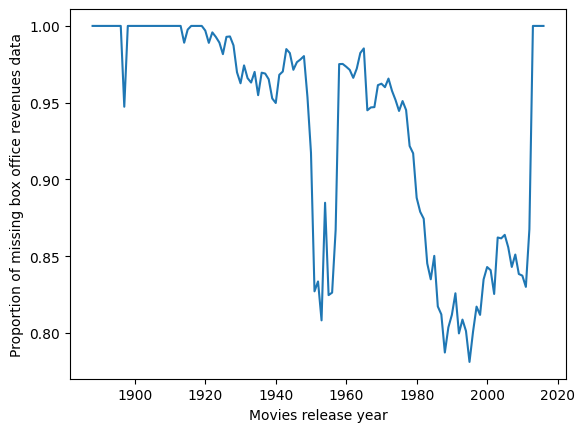

In [8]:
missing_percentages = movies.groupby('Movie release year')['Movie box office revenue'].apply(lambda x: x.isna().mean())
missing_percentages.plot(xlabel='Movies release year', ylabel='Proportion of missing box office revenues data')

## Load IMDb ratings dataset

In [9]:
# Load the titles dataset
titles = pd.read_csv("./data/IMDb/titles.tsv", sep='\t', usecols=[0,2])
display(titles.head())

# Load the details of each title (movies)
titles_details = pd.read_csv("./data/IMDb/titles_details.tsv", sep='\t', usecols=[0,5])
display(titles_details.head())

# Load the ratings dataset
ratings = pd.read_csv("./data/IMDb/ratings.tsv", sep='\t')
ratings = ratings.rename(columns={'averageRating': 'Average rating', 'numVotes': 'Number of votes'})

# Convert data types to integers for specific columns
columns = ["Number of votes"]
for column in columns:
  ratings[column] = ratings[column].astype("Int64")

display(ratings.head())

,titleId,title
0,tt0000001,Карменсіта
1,tt0000001,Carmencita
2,tt0000001,Carmencita - spanyol tánc
3,tt0000001,Καρμενσίτα
4,tt0000001,Карменсита


,tconst,startYear
0,tt0000001,1894
1,tt0000002,1892
2,tt0000003,1892
3,tt0000004,1892
4,tt0000005,1893


,tconst,Average rating,Number of votes
0,tt0000001,5.7,2006
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2689


## Merge the datasets

Resulting usable dataframes are:

- movies: includes each movie with the ratings but without the details of the characters

- characters_movies: includes each character with its corresponding movie and ratings

In [10]:
# Merge the different IMDb datasets together, then delete no longer relevant dataframes to free the RAM
titles = pd.merge(titles, titles_details, left_on="titleId", right_on="tconst")
del titles_details
ratings = pd.merge(ratings, titles, on="tconst")
del titles
# convert the years to integers using datetime
ratings["startYear"] = ratings["startYear"].astype(str).replace(r'\N', np.nan).apply(lambda x: parse(x) if not pd.isna(x) else pd.NaT).dt.year.astype('Int64')
ratings.head()

,tconst,Average rating,Number of votes,titleId,title,startYear
0,tt0000001,5.7,2006,tt0000001,Карменсіта,1894
1,tt0000001,5.7,2006,tt0000001,Carmencita,1894
2,tt0000001,5.7,2006,tt0000001,Carmencita - spanyol tánc,1894
3,tt0000001,5.7,2006,tt0000001,Καρμενσίτα,1894
4,tt0000001,5.7,2006,tt0000001,Карменсита,1894


In [11]:
# Merge the movies dataset (CMU) with the ratins dataset (IMDb), remove duplicates and delete no longer relevant dataframe to free the RAM
movies = pd.merge(movies, ratings, left_on=["Movie name","Movie release year"], right_on=["title","startYear"], how="left").drop_duplicates().drop(columns=["tconst","titleId","title","startYear"]).drop_duplicates(['Freebase movie ID'])
del ratings

# Clean languages, countries and genres columns by removing unnecessary ID's
columns = ["Movie languages","Movie countries","Movie genres"]
for column in columns:
  movies[column] = movies[column].apply(lambda string: list(json.loads(string).values()))

movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release year,Inflation-adjusted box office revenue,Average rating,Number of votes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,1.898756e+07,4.9,56912
11,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,NaN,NaN,<NA>
12,28463795,/m/0crgdbh,Brun bitter,1988-12-22,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988,NaN,5.6,40
14,9363483,/m/0285_cd,White Of The Eye,1987-12-22,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,NaN,NaN,<NA>
15,261236,/m/01mrr1,A Woman in Flames,1983-12-22,NaN,106.0,[German Language],[Germany],[Drama],1983,NaN,5.9,623


In [12]:
# Final merge between the characters and movies dataset
characters_movies = characters.merge(movies, on=["Freebase movie ID","Wikipedia movie ID"])

# Clean the dataset by removing the Freebase ID's in the database (might be useful to keep the ID's in the future though)
characters_movies = characters_movies.drop(columns=["Wikipedia movie ID","Freebase movie ID","Freebase character ID","Freebase actor ID","Freebase character/actor map ID"])

characters_movies.head()

,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release year,Inflation-adjusted box office revenue,Average rating,Number of votes
0,Akooshay,1958-08-26 00:00:00,F,1.620,NaN,Wanda De Jesus,42,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,1.898756e+07,4.9,56912
1,Lieutenant Melanie Ballard,1974-08-15 00:00:00,F,1.780,/m/044038p,Natasha Henstridge,27,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,1.898756e+07,4.9,56912
2,Desolation Williams,1969-06-15 00:00:00,M,1.727,/m/0x67,Ice Cube,32,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,1.898756e+07,4.9,56912
3,Sgt Jericho Butler,1967-09-12 00:00:00,M,1.750,NaN,Jason Statham,33,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,1.898756e+07,4.9,56912
4,Bashira Kincaid,1977-09-25 00:00:00,F,1.650,NaN,Clea DuVall,23,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,1.898756e+07,4.9,56912


## Data cleaning and verification

In [13]:
# Check that every element in each column of the dataframes have the same type
display(movies.dtypes)
display(characters_movies.dtypes)

Wikipedia movie ID                                int64
Freebase movie ID                                object
Movie name                                       object
Movie release date                       datetime64[ns]
Movie box office revenue                        float64
Movie runtime                                   float64
Movie languages                                  object
Movie countries                                  object
Movie genres                                     object
Movie release year                                Int64
Inflation-adjusted box office revenue           float64
Average rating                                  float64
Number of votes                                   Int64
dtype: object

Character name                                   object
Actor date of birth                              object
Actor gender                                     object
Actor height (in meters)                        float64
Actor ethnicity (Freebase ID)                    object
Actor name                                       object
Actor age at movie release                        Int64
Movie name                                       object
Movie release date                       datetime64[ns]
Movie box office revenue                        float64
Movie runtime                                   float64
Movie languages                                  object
Movie countries                                  object
Movie genres                                     object
Movie release year                                Int64
Inflation-adjusted box office revenue           float64
Average rating                                  float64
Number of votes                                 

## Store the generated dataframes in binary format

In [14]:
movies.to_pickle("./data/movies_df_pickle")
characters_movies.to_pickle("./data/characters_movies_df_pickle")

# Movie genres clustering

In [15]:
from plotly.subplots import make_subplots
import matplotlib.ticker as mtick

Reload the dataset:

In [16]:
movies = pd.read_pickle("./data/movies_df_pickle")

In [17]:
# This part is used to clean our data set

def convert_list_to_lowercase(lst): #The function convert all the letter, in a list, to lowercase
    return [item.lower() for item in lst]

movies['Movie genres'] = movies['Movie genres'].apply(lambda x: convert_list_to_lowercase(x)) #We convert all the genre in lowercase to ease the categorization

# We create the categorisation that we will use later to assign all the different genres to more general genre
movie_genre_categories = {
    "Action & Adventure": [
        "action", "action comedy", "action thrillers", "action/adventure", "adventure",
        "adventure comedy", "b-movie", "caper story", "chase movie", "epic", "epic western",
        "escape film", "heist", "road movie", "swashbuckler films"
    ],
    "Drama & Romance": [
        "addiction drama", "biographical film", "biopic", "coming of age", "coming-of-age film",
        "courtroom drama", "drama", "family drama", "marriage drama", "melodrama", "romantic drama",
        "romantic fantasy", "romantic thriller", "tragedy", "tragicomedy"
    ],
    "Comedy": [
        "black comedy", "buddy picture", "buddy film", "camp", "comedy", "comedy thriller",
        "comedy film", "comedy-drama", "domestic comedy", "gross-out film", "humour",
        "musical comedy", "parody", "romantic comedy", "screwball comedy", "sex comedy",
        "slapstick", "workplace comedy"
    ],
    "Horror & Thriller": [
        "alien film", "creature film", "cult", "gothic film", "haunted house film", "horror",
        "horror comedy", "monster", "monster movie", "psychological horror", "slasher",
        "splatter film", "supernatural", "thriller", "vampire movies", "werewolf fiction",
        "zombie film"
    ],
    "Science Fiction & Fantasy": [
        "alien invasion", "apocalyptic and post-apocalyptic fiction", "cyberpunk", "dystopia",
        "fantasy", "fantasy adventure", "mythological fantasy", "sci-fi adventure", "sci-fi horror",
        "sci-fi thriller", "science fiction", "space opera", "superhero", "superhero movie",
        "time travel"
    ],
    "Historical & Biographical": [
        "biographical film", "epic", "historical documentaries", "historical epic",
        "historical drama", "historical fiction", "period piece"
    ],
    "Crime & Mystery": [
        "crime", "crime comedy", "crime drama", "crime thriller", "detective", "detective fiction",
        "film noir", "gangster film", "heist", "mystery", "neo-noir", "police procedural", "whodunit"
    ],
    "Documentary & Realism": [
        "anthropology", "archival footage", "documentary", "docudrama", "educational",
        "journalism", "nature", "realism", "social problem film"
    ],
    "Musical & Performing Arts": [
        "backstage musical", "dance", "jukebox musical", "musical", "musical drama", "opera",
        "performance art"
    ],
    "Animation & Experimental": [
        "animated cartoon", "animation", "anime", "clay animation", "computer animation",
        "experimental film", "stop motion"
    ]
}


def assign_category(genres): #This function assigne the genres to the more general genre using the movie_genre_categories
    categories = []
    for genre in genres:
        for category, genre_list in movie_genre_categories.items():
            if genre in genre_list:
                categories.append(category)
                break
        else:
            categories.append('Other')
    return categories


movies['Dictionnary Movie genres'] = movies['Movie genres'].apply(assign_category)

movies = movies.dropna(subset=['Inflation-adjusted box office revenue']) #We drop the movies that doesn't have any revenue

Here, we load the dataset about the movie and since there are 363 different genres, some typo and same data genre with different names, we want to clean and regroup them into more general clusters of movie genre.

To do this, we have chosen to classify them into ten main movie genres. This is an arbitrary choice motivated by the size of dataset and relevance of clustering. The clustering of all the genres is performed using a large language model which sorts each label and relates it to its closest counterpart. All the genres that don't fit well with the main genres are assigned to an 'Other' category.

Before the actual processing, we started by converting all the letters to lower case to ensure a better classification. This allowed us to do two things: remove all spelling mistakes, upper/lower case and any other type of mistake that led to an unintended duplication of genres.

For example, "black comedy", "comedy", "comedy thriller", "comedy film", "comedy-drama", "domestic comedy", "gross-out film", "humour", "musical comedy", "romantic comedy", "screwball comedy", "sex comedy", "workplace comedy", are clustered together.


## Distribution of Genres

In [18]:
# Since a single movie can have multiple genre and we want to assigne one genre per movie, we copy the movie with a different genre everytime
movies_genre = movies.explode('Dictionnary Movie genres').copy(deep=True)

# As a film can have several genres assigned to the same more general genre, this creates copies of the same exact data
# To adress this, we're dropping the data with the same movie ID and dictionary genre
movies_genre= movies_genre.drop_duplicates(subset=['Freebase movie ID', 'Dictionnary Movie genres'])

# Drop 'Other' genre since it's made of the rest of the movies genres and is not usable
movies_genre = movies_genre[movies_genre['Dictionnary Movie genres'] != 'Other']

# Counting genres
genre_counts = movies_genre['Dictionnary Movie genres'].value_counts()

# Select top 5 genres
top_genres = genre_counts.head(5)

# Sum the remaining genres and label them as 'Others'
others_count = genre_counts[5:].sum()
other_genres = pd.Series({'Others': others_count})

plot_data = pd.concat([top_genres, other_genres]).reset_index()
plot_data.rename(columns={'index': 'Genre', 0: 'Count'}, inplace=True)

fig = px.pie(plot_data, values='Count', names='Genre', title='Top Movie Genres')

# Save and show the figure
#fig.write_html("./plots/adam_camember.html")
fig.show()


We created a pie chart to visualise how the movie genres are distributed. This allow us to have a quick look at the movie distribution, assigned to the main genres.

The genre "Drama & Romance" is the most common in the dataset, making up a quarter of the movies. "Comedy" and "Action & Adventure" also represent significant portions, while "Horror & Thriller" and "Crime & Mystery" are less represented but still significant.

The "Others" category, which represents the aggregated total of the least common genres, makes up a larger slice than two individual genres, indicating that the movies genres follows a heavy-tailed distribution.

But so far, this analysis doesn't say much about the changes over time and how they are distributed with respect to the revenue they generated. The next plot should be more informative in this regard.

In [19]:
# To smooth the graph, we used a mean made over 3 years by assigning a specific year for each 3-years period
movies_genre['Period'] = movies_genre['Movie release year'] // 3 * 3

# As in the pie chart, we count the genres occurence but this time, we do it by period
genre_counts = movies_genre.groupby(['Period', 'Dictionnary Movie genres']).size().unstack(fill_value=0)

genre_sums = genre_counts.sum(axis=0)

#We choose only the five most occured genres
top_genres = genre_sums.nlargest(5).index
top_genre_counts = genre_counts[top_genres]

top_genre_counts['Other'] = genre_counts.drop(columns=top_genres).sum(axis=1)

# We transform the count in percentage
genre_percentages = top_genre_counts.divide(top_genre_counts.sum(axis=1), axis=0) * 100

fig = go.Figure()


for genre in genre_percentages.columns:
    fig.add_trace(go.Scatter(
        x=genre_percentages.index,
        y=genre_percentages[genre],
        hoverinfo='x+y',
        mode='lines',
        line_shape='spline',
        name=genre,
        stackgroup='one'
    ))

fig.update_layout(
    title='Top 5 movies genres distribution over time ',
    showlegend=True,
    xaxis=dict(
        title='Years',
        type='linear'
    ),
    yaxis=dict(
        title='Genre occurence (percentage)',
        type='linear',
        range=[1, 100],
        ticksuffix='%'
    )
)

# Saving the figure
#fig.write_html("./plots/adam_strats.html")


fig.show()


/tmp/ipykernel_2058/916841474.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The advantage of this graph, compared to the pie chart, is the evolution over time. This allows us to have a combined visualization of the main genres evolution over time. Now, we can observe trend shifts from this plot.

In the early 20s, we observe that Drama & Romance as well as Action & Adventure were the only genres included in the dataset. In particular we can observe the decrease in the "Drama & Romance" dominance over time, shifting from a 60% to a 20% market share over the years. Comedy as well as Action & Adventure has followed a steady trend. Horror and thriller movies have sustained a modest growth over time.

Overall, the graph suggests a poor diversity at the beginning of the 1900's, but the cinematographic industry since has vested into a variety of other movie genres.

For the next step, we wanted to direct our attention to the average box office revenue generated by each genre. We have created an interactive plot where you can select the average revenue distributions from our larger set of 10 genres.

In [20]:
# This function is used to group years into periods. For instance, if the year is 2021, it will return "2021-2023".
def assign_period(year):
    return f"{year - year % 3}-{year - year % 3 + 2}"


movies_genre['Period_new'] = movies_genre['Movie release year'].apply(assign_period)

# Group by genre and period, then calculate the mean revenue
grouped = movies_genre.groupby(['Dictionnary Movie genres', 'Period_new'])['Inflation-adjusted box office revenue'].mean().reset_index()

#The grouped DataFrame is pivoted to have 'Period_new' as the index and genres as columns with mean revenues as values, which facilitates the creation of the bar chart
pivot_df = grouped.pivot(index='Period_new', columns='Dictionnary Movie genres', values='Inflation-adjusted box office revenue')

fig = make_subplots(specs=[[{"secondary_y": True}]])

first_genre = pivot_df.columns[0]
buttons = []

for genre in pivot_df.columns:
    visible = True if genre == first_genre else False
    fig.add_trace(
        go.Bar(x=pivot_df.index, y=pivot_df[genre], name=genre, visible=visible),
        secondary_y=False,
    )
    buttons.append(
      dict(
          method='update',
          label=genre,
          args=[{'visible': [genre == g for g in pivot_df.columns]},
                {'title': f'Mean Revenue for {genre} Movies'}]
      )
    )

fig.update_layout(
    title_text="Mean Revenue by Movie Genre",
    xaxis_title="Year",
    yaxis_title="Mean Revenue",
    barmode='group'
)


all_revenues = pivot_df.to_numpy().flatten()
all_revenues = all_revenues[~np.isnan(all_revenues)]
min_revenue = np.min(all_revenues)
max_revenue = np.max(all_revenues)

y_ticks = [10**i for i in range(int(np.log10(min_revenue)), int(np.log10(max_revenue))+1)]
fig.update_yaxes(type="log", tickvals=y_ticks, secondary_y=False)

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.01,
            xanchor="left",
            y=1.16,
            yanchor="top"
        ),
    ]
)

periods = pivot_df.index
tickvals_x = [period for period in periods if int(period.split('-')[0]) % 5 == 0]
ticktext_x = [period.split('-')[0] for period in periods if int(period.split('-')[0]) % 5 == 0]


fig.update_xaxes(
    tickmode='array',
    tickvals=tickvals_x,
    ticktext=ticktext_x,
    tickangle=0
)


#fig.write_html("./plots/adam_genre_revenu.html")

fig.show()

Since we adjusted the revenu of each movie with the inflation, we are now allowed to calculate the mean revenue for each genre through the all time span.

We are well aware that other factors than inflation can have an effect on the financial performance of a movie like money invested, the number of cinemas and their affordability (price of ticket).

In [21]:
mean_genre_revenue = movies_genre.groupby('Dictionnary Movie genres')['Inflation-adjusted box office revenue'].mean().reset_index()

mean_genre_revenue_sorted = mean_genre_revenue.sort_values(by='Inflation-adjusted box office revenue', ascending=False)

print(mean_genre_revenue_sorted)

    Dictionnary Movie genres  Inflation-adjusted box office revenue
1   Animation & Experimental                           2.139473e+08
9  Science Fiction & Fantasy                           1.797918e+08
0         Action & Adventure                           1.366710e+08
8  Musical & Performing Arts                           1.014427e+08
7          Horror & Thriller                           9.812024e+07
6  Historical & Biographical                           8.425793e+07
2                     Comedy                           7.754660e+07
3            Crime & Mystery                           7.747916e+07
5            Drama & Romance                           7.477416e+07
4      Documentary & Realism                           6.426603e+07


For the following analysis, we used an ANOVA test to determine if there is a significant difference in the mean revenue between the genres.

In [22]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Perform ANOVA test to see if there are significant differences in revenues across genres
anova_results = smf.ols('Q("Inflation-adjusted box office revenue") ~ C(Q("Dictionnary Movie genres"))',
                    data=movies_genre).fit()
anova_table = sm.stats.anova_lm(anova_results, typ=2)

if anova_table['PR(>F)'][0] < 0.05:

    print('There is a significant difference found by ANOVA')
else:
    print("No significant difference found by ANOVA.")

There is a significant difference found by ANOVA


/tmp/ipykernel_2058/2962177504.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



An analysis of variance (ANOVA) is used to check whether there are statistically significant differences between more than two samples. To do this, the means and variances of the respective groups are compared.

The ANOVA test include a null hypothesis that indicates if there is any difference in means. The result of an ANOVA test is an F-statistic, which is a ratio of two types of variances: Between-group variance (how much the group means deviate from the overall mean) and within-group variance (how much the individual observations deviate from their respective group means).

The F-statistic is used to calculate a p-value, which indicates the probability of obtaining at least as extreme results given that the null hypothesis is true. A low p-value (typically less than 0.05) suggests that the group means are not all equal in the population.

## Language analysis

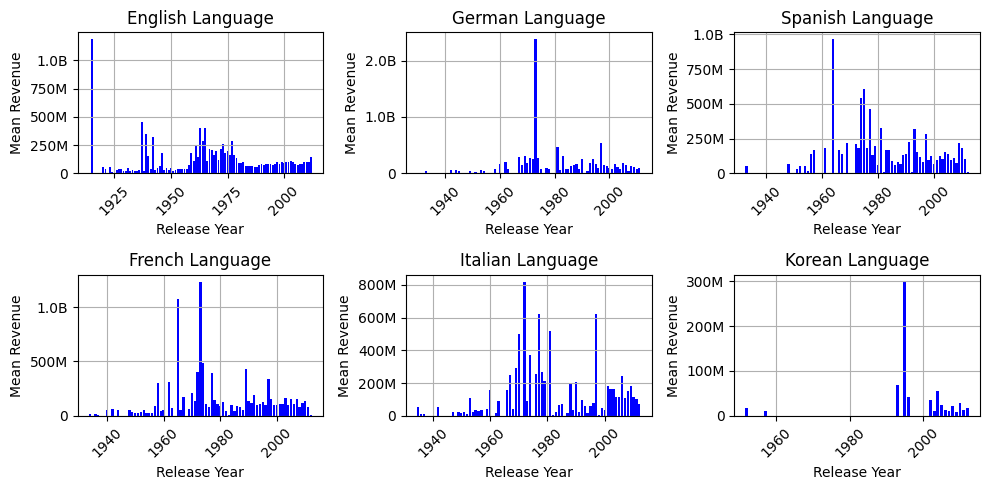

In [23]:
# Since the language are stored in list and a movie can have multiple languages
# we explode them to have only one language per movie and we duplicate the movies with multiples languages
movies_language = movies.explode('Movie languages').copy(deep=True)


language_counts = movies_language['Movie languages'].value_counts()

# Get the counts of each language and select the top 6
selected_languages = movies_language['Movie languages'].value_counts().head(6).index.tolist()


# Filter the DataFrame to keep only the rows with the top 6 languages
movies_filtered = movies_language[movies_language['Movie languages'].isin(selected_languages)]

mean_revenue_per_language = movies_filtered.groupby(['Movie release year', 'Movie languages'])['Inflation-adjusted box office revenue'].mean().reset_index()

unique_languages = mean_revenue_per_language['Movie languages'].unique()

num_cols = 3
num_rows = (len(unique_languages) + num_cols - 1) // num_cols

plt.figure(figsize=(10, 5))

# Define a formatter function that will convert numbers to strings with 'M' or 'B' as appropriate
def millions_billions_formatter(x, pos):
    if x >= 1e9:
        return f'{x*1e-9:.1f}B'
    elif x >= 1e6:
        return f'{x*1e-6:.0f}M'
    return f'{x:.0f}'

for i, language in enumerate(unique_languages):
    ax = plt.subplot(num_rows, num_cols, i+1)
    language_data = mean_revenue_per_language[mean_revenue_per_language['Movie languages'] == language]

    # Plot the bar chart
    ax.bar(language_data['Movie release year'], language_data['Inflation-adjusted box office revenue'], color='blue')

    # Set the custom formatter for y-axis
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(millions_billions_formatter))

    plt.xlabel('Release Year')
    plt.ylabel('Mean Revenue')
    plt.title(language)
    plt.xticks(rotation=45)
    plt.grid(True)

plt.tight_layout()
plt.show()

Here, we did the same as for the genre but with the language instead. We kept the five most frequent movie languages. We wanted an easy and quick visualization used for comparison of the movie languages. From these plots, we can compare languages from the same period and also observe the evolution of each language over time. This also allows us to extract a tendency.

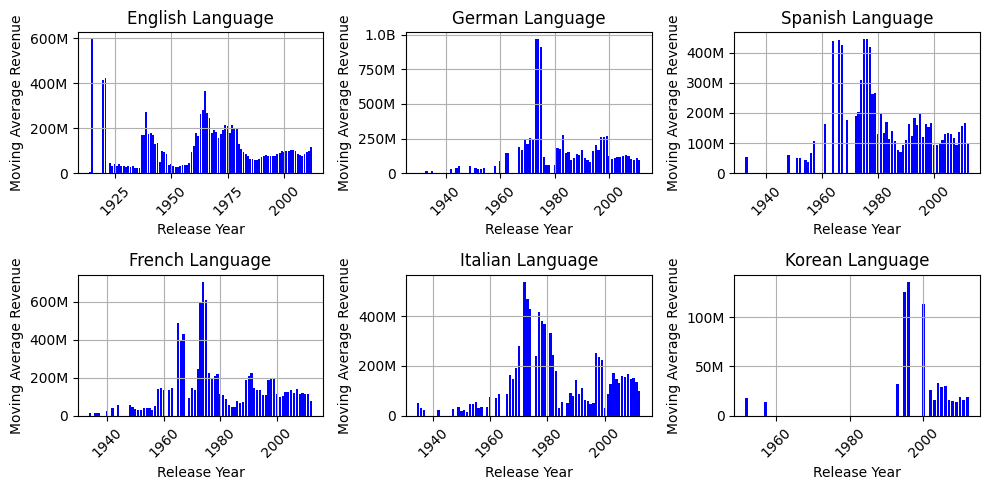

In [24]:
plt.figure(figsize=(10, 5))

# Define a formatter function that will convert numbers to strings with 'M' or 'B' as appropriate
def millions_billions_formatter(x, pos):
    if x >= 1e9:
        return f'{x*1e-9:.1f}B'
    elif x >= 1e6:
        return f'{x*1e-6:.0f}M'
    return f'{x:.0f}'

for i, language in enumerate(unique_languages):
    language_data = mean_revenue_per_language[mean_revenue_per_language['Movie languages'] == language].sort_values('Movie release year')

    # Calculate the moving average
    language_data['Moving Average'] = language_data['Inflation-adjusted box office revenue'].rolling(window=3, min_periods=1).mean()

    # Create subplot for each language
    ax = plt.subplot(num_rows, num_cols, i+1)

    # Plot the bar chart
    ax.bar(language_data['Movie release year'], language_data['Moving Average'], color='blue', label='Moving Average')

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(millions_billions_formatter))

    plt.xlabel('Release Year')
    plt.ylabel('Moving Average Revenue')
    plt.title(language)
    plt.xticks(rotation=45)
    plt.grid(True)

plt.tight_layout()
plt.show()


For a smoother aspect of the plot, a moving average was performed. It removes the short term fluctuations and allows to analyze trends, at the cost of loosing granularity in the data points.

With our analysis, we could predict future box office basing our assumptions on the trends and evolution over time. For this reason, the smoothing of our data is well suited.

In [25]:
movies_filtered['Period'] = movies_filtered['Movie release year'].apply(assign_period)

grouped = movies_filtered.groupby(['Movie languages', 'Period'])['Inflation-adjusted box office revenue'].mean().reset_index()

pivot_df = grouped.pivot(index='Period', columns='Movie languages', values='Inflation-adjusted box office revenue')

fig = make_subplots(specs=[[{"secondary_y": True}]])


for language in pivot_df.columns:
    visible = True if language == pivot_df.columns[0] else False
    fig.add_trace(
        go.Bar(x=pivot_df.index, y=pivot_df[language], name=language, visible=visible),
        secondary_y=False,
    )

fig.update_layout(
    title_text="Mean Revenue by Movie language",
    xaxis_title="Year",
    yaxis_title="Mean Revenue",
    barmode='group'
)


all_revenues = pivot_df.to_numpy().flatten()
all_revenues = all_revenues[~np.isnan(all_revenues)]
min_revenue = np.min(all_revenues)
max_revenue = np.max(all_revenues)

y_ticks = [10**i for i in range(int(np.log10(min_revenue)), int(np.log10(max_revenue))+1)]
fig.update_yaxes(type="log", tickvals=y_ticks, secondary_y=False)

buttons = []
for language in pivot_df.columns:
    buttons.append(
        dict(
            method='update',
            label=language,
            args=[{'visible': [language == l for l in pivot_df.columns]},
                  {'title': f'Mean Revenue for {language} Movies'}]
        )
    )

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.01,
            xanchor="left",
            y=1.15,
            yanchor="top"
        ),
    ]
)

# Extract the first year from each period and show every other period
periods = pivot_df.index
tickvals_x = [period for period in periods if int(period.split('-')[0]) % 5 == 0]
ticktext_x = [period.split('-')[0] for period in periods if int(period.split('-')[0]) % 5 == 0]


fig.update_xaxes(
    tickmode='array',
    tickvals=tickvals_x,
    ticktext=ticktext_x,
    tickangle=0
)

#fig.write_html("./plots/adam_language_revenu.html")

fig.show()


/tmp/ipykernel_2058/3594739293.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



To enhance our comprehension of the data distribution, we will delve into a more informative type of data representation.

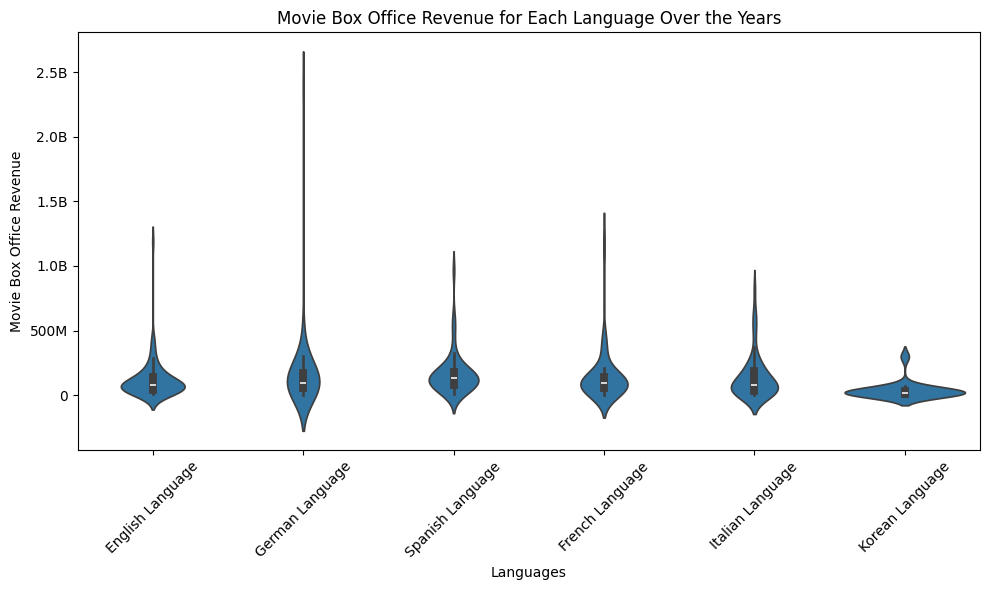

In [26]:
plt.figure(figsize=(10, 6))

ax = sns.violinplot(x='Movie languages', y='Inflation-adjusted box office revenue', data=mean_revenue_per_language)
plt.xlabel('Languages')
plt.ylabel('Movie Box Office Revenue')
plt.title('Movie Box Office Revenue for Each Language Over the Years')
plt.xticks(rotation=45)

ax.yaxis.set_major_formatter(mtick.FuncFormatter(millions_billions_formatter))

plt.tight_layout()
plt.show()


Violin plots are useful because they immediately provide the density of the distribution, the median, quartiles range as well as the outliers.

The plot is interesting because some languages, like German anf French, having a wider range of revenues (potentially indicating both low and high gross revenues of movies). Others, like Korean and English, have a narrower distribution (potentially more consistent revenue figures).

Some languages, like the Korean, has a high density of data around a the median revenue, as indicated by the thickness of the violins.

## Runtime analysis

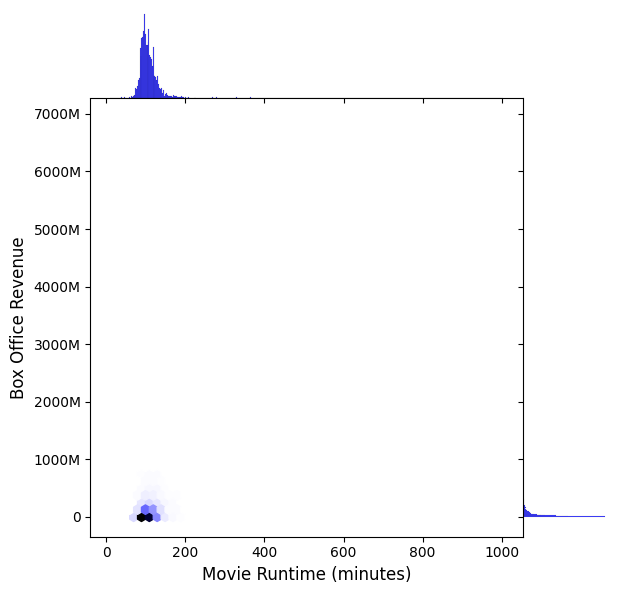

In [27]:
g = sns.jointplot(
    x='Movie runtime',
    y='Inflation-adjusted box office revenue',
    data=movies_filtered,
    kind='hex',  # Kernel density estimate for contour
    space=0,     # No space between the joint and marginal plots
    color='blue'
)

# Set new axis labels
g.set_axis_labels('Movie Runtime (minutes)', 'Box Office Revenue', fontsize=12)

# Apply the custom formatter to the y-axis
formatter = mtick.FuncFormatter(lambda x, pos: f'{x*1e-6:.0f}M' if x >= 1e6 else f'{x:.0f}')
g.ax_joint.yaxis.set_major_formatter(formatter)

# Show the plot
plt.show()


We can see on this plot there seems to be no linear relationship between revenue and runtime. Furthermore, the movie runtime data seems normaly distributed around 100 minutes of movie length.

## Rating analysis

/tmp/ipykernel_2058/3555361437.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2058/3555361437.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




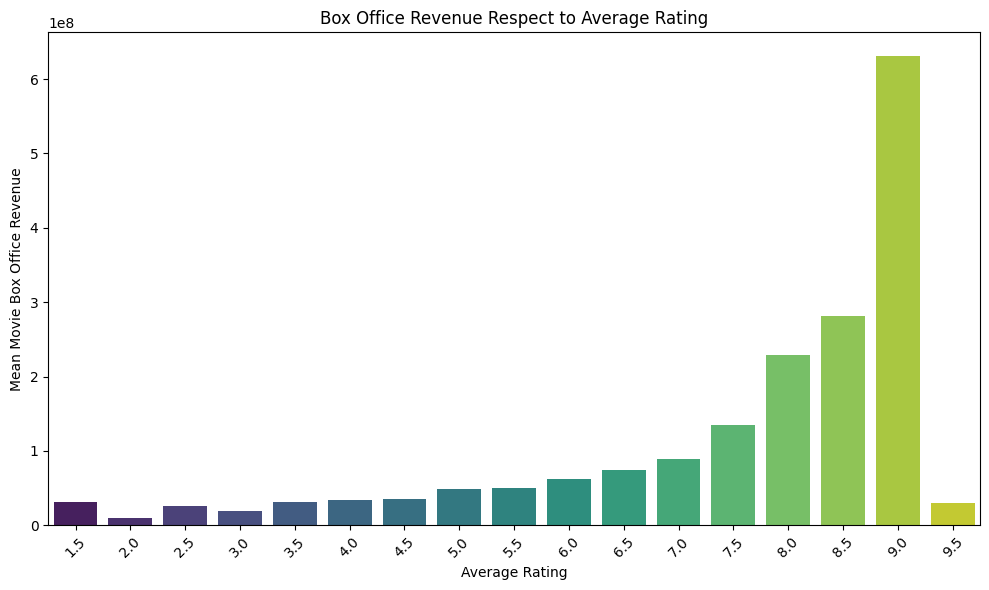

In [28]:
#We dropped all the movies that don't have any rating
movies_wo_nan = movies.dropna(subset=['Average rating'])

#We regrouped the movies rating to the nearest 0.5 rating groups (e.g., 3.3 = 3.5, 4.1 = 4.0)
movies_wo_nan['Rating Group'] = movies_wo_nan['Average rating'].apply(lambda x: round(x * 2) / 2)
mean_revenue_per_half_rating = movies_wo_nan.groupby('Rating Group')['Inflation-adjusted box office revenue'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Rating Group', y='Inflation-adjusted box office revenue', data=mean_revenue_per_half_rating, palette='viridis')
plt.xlabel('Average Rating')
plt.ylabel('Mean Movie Box Office Revenue')
plt.title('Box Office Revenue Respect to Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


We computed and displayed the mean revenue of the movies with respect to their rating. Unsurprisingly, the graph indicates the higher the ratings, the higher the box office revenues will be. This suggests that, on average, higher-rated movies tend to generate more revenue at the box office.
The highest revenue is associated with movies that have an average rating of 9.0, which is significantly higher than all other ratings. The lowest box office revenue is associated with movies that have the lowest average ratings (1.5 to 2.5). Overall, we concur that a few high-grossing blockbusters could skew the average revenue upward for a particular rating. For example, the data doesn’t account for other factors that can influence box office revenue, such as marketing budgets, the presence of star actors, genre, seasonal release dates, and competition from other movies at the time of release.

# Genders and revenue

In [29]:
from scipy.stats import t
import scipy.stats as stats

from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display

## Starting visualisation

We will start by having an overview of the data at our disposal for this analysis. This will guide us about what study we must conduct in order to be able to obtain meaniningful results.

In [30]:
characters_movies = pickle.load(open('data/characters_movies_df_pickle', 'rb'))
df_gilles=characters_movies.copy()

In [31]:
# Gender distribution over the years
gender_distribution = df_gilles.groupby(['Movie release year', 'Actor gender']).size().unstack()
gender_distribution = gender_distribution.dropna() # For the few cases where there are no gender represented
years_array = gender_distribution.index.astype(int).to_numpy() # It's easier to do custom graph with those
# Calculate total number of movies for each year
total_movies_per_year = df_gilles.groupby('Movie release year').size()

# Add the total number of movies as a new column in the gender distribution DataFrame in order to be able to have errorbars
gender_distribution['Total Movies'] = total_movies_per_year

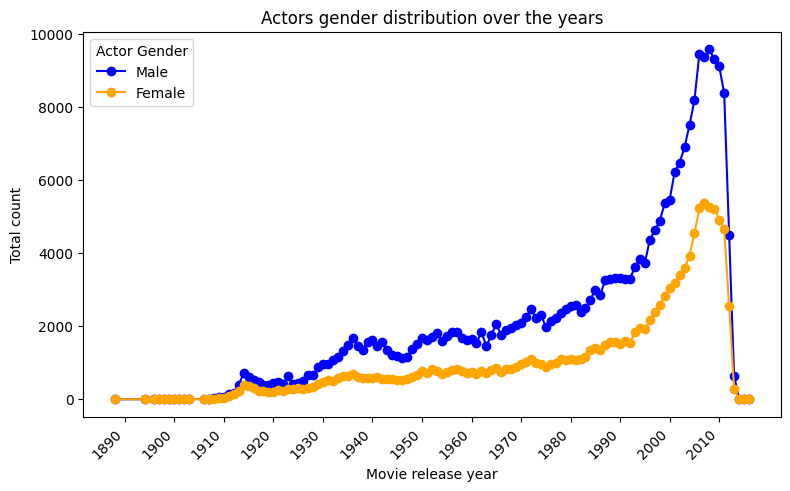

In [32]:
plt.figure(figsize=(9, 5))

# 2 curves
plt.plot(years_array, gender_distribution['M'], marker='o', linestyle='-', color='Blue', label='Male')
plt.plot(years_array, gender_distribution['F'], marker='o', linestyle='-', color='orange', label='Female')

plt.title('Actors gender distribution over the years')
plt.xlabel('Movie release year')
plt.ylabel('Total count')

# Incline X-axis ticks
plt.xticks(np.arange(years_array[0]+2, years_array[-1], 10), rotation=45, ha='right')

# Move legend inside the graph space and position at the top left
plt.legend(title='Actor Gender', loc='upper left', bbox_to_anchor=(0, 1))

plt.show()

This chart traces the gender distribution of movie actors over time, reflecting an upward trend for both male and female actors, with a significantly steeper increase for males. The widening gap suggests a gender disparity that merits further examination within the historical context of the film industry's growth and societal gender roles.

The post-2010 decline is probably due to the end of the dataset and a great dimished data colelction for the last few years.

Now, since it's a bit hard to decipher information from this, we will instead look at the ratio of male actors in movies per year to check if there is any clearly visible trend.

We'll only consider years with a certain number of registered movies. This should help avoid nonsensical data based on too few movies.

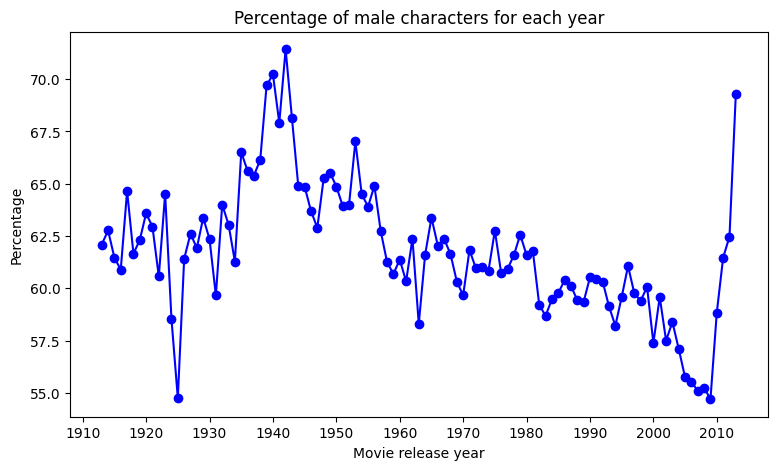

In [33]:
threshold = 500

# Calculate percentage of male and female characters for each year
gender_percentage = gender_distribution[['M', 'F']].div(gender_distribution['Total Movies'], axis=0) * 100

# Filter years where the combined count of M and F is less than a threshold (adjust threshold as needed)
filtered_years = gender_percentage.index[(gender_distribution['Total Movies'] >= threshold)]

# Plotting
plt.figure(figsize=(9, 5))
plt.plot(filtered_years, gender_percentage.loc[filtered_years, 'M'], marker='o', linestyle='-', color='blue', label='Male')
#plt.plot(filtered_years, gender_percentage.loc[filtered_years, 'F'], marker='o', linestyle='-', color='orange', label='Female')

plt.title('Percentage of male characters for each year')
plt.xlabel('Movie release year')
plt.ylabel('Percentage')

# Better X axis
plt.xticks(np.arange(filtered_years[0]-3, filtered_years[-1], 10))
plt.show()


This chart presents the annual percentage of male characters, revealing a relatively stable ratio over time with minor fluctuations. A modest decline is observed as we approach 2010, likely indicative of gradual shifts in gender representation. The abrupt rise thereafter suggests a data irregularity due to a smaller sample size in recent years, rather than a genuine trend reversal. This highlights the importance of considering sample size when interpreting data, as anomalies may distort the understanding of long-term patterns.

## Shall we consider ethnicity ?

Ethnicity is only refered in the data given by hash. Getting acces to what those hash refers too is a complex process due to a database migration that depreciated them. We would need to find another dataset in order to get the information. We were hesitant as to do a discussion on ethnicity of actors. Let's see how many different ethnicities are represented in the dataframe.

In [34]:
# Drop duplicate actors, keeping only the first occurrence
unique_actors = df_gilles.drop_duplicates(subset='Actor name')
# Count the number of unique actors for each ethnicity
ethnicity_counts = unique_actors.groupby('Actor ethnicity (Freebase ID)').size()
# Print or use the counts as needed
print("Ethnicity Counts:")
print(ethnicity_counts)

Ethnicity Counts:
Actor ethnicity (Freebase ID)
/m/01267        2
/m/012c1l       7
/m/012f86       7
/m/012fh        1
/m/01336l      30
             ... 
/m/0j4w_        2
/m/0j6x8       17
/m/0x67      1464
/m/0xff         2
/m/0xnvg      139
Length: 479, dtype: int64


There are many ethnicities, so it would be hard to make sense of it. Ethnicity seems like a good idea in theory, but it is too precise of a metric to really be able to take into account when making any sort of diversity comment.

## What's in the best ?

Since the box office follows a heavy-tailed distribution, and if the goal is to maximize profit, we want to conduct an analysis and focus on information related to the best-performing movies. Instead of considering every movie, and to align with our research focus, we will now exclusively examine the most successful movie of a given period (a decade appears to be the most suitable). Success can be determined by either box office revenue or ratings. The following plots take into account only the top X% of movies within each N-year range.

In [35]:
top = 20
year_range = 10
threshold = 100

# Create N-year range groups
df_gilles['Year group'] = (df_gilles['Movie release year'] // year_range) * year_range

# Calculate the number of movies needed to cover the top X% for each group
num_movies_to_select = (
    df_gilles.groupby('Year group')
    .apply(lambda group: int(len(group) * top / 100))
    .astype(int)
    .to_dict()
)

# Filter out groups with less than the threshold number of movies
valid_groups = df_gilles['Year group'].value_counts() >= threshold
df_gilles_filtered = df_gilles[df_gilles['Year group'].isin(valid_groups[valid_groups].index)]

# Select the top X% for each group based on box office revenue
sorted_BO = df_gilles_filtered.sort_values(by=['Year group', 'Movie box office revenue'], ascending=[True, False])
top_movies_BO = sorted_BO.groupby('Year group').apply(lambda group: group.head(num_movies_to_select[group.name]))
top_movies_BO = top_movies_BO.reset_index(drop=True)

# Same for rating
sorted_rating = df_gilles_filtered.sort_values(by=['Year group', 'Average rating'], ascending=[True, False])
num_movies_to_select_rating = sorted_rating.groupby('Year group').apply(lambda group: int(len(group) * top / 100))

# Select the top X% for each group based on rating
top_movies_rating = sorted_rating.groupby('Year group').apply(lambda group: group.head(num_movies_to_select_rating[group.name]))
top_movies_rating = top_movies_rating.reset_index(drop=True)

# Calculate the number of movies in each year group
num_movies_in_year_group = df_gilles['Year group'].value_counts().sort_index()

# Add the number of movies in each year group as a new column in df_gilles
df_gilles['Num movies in year group'] = df_gilles['Year group'].map(num_movies_in_year_group)

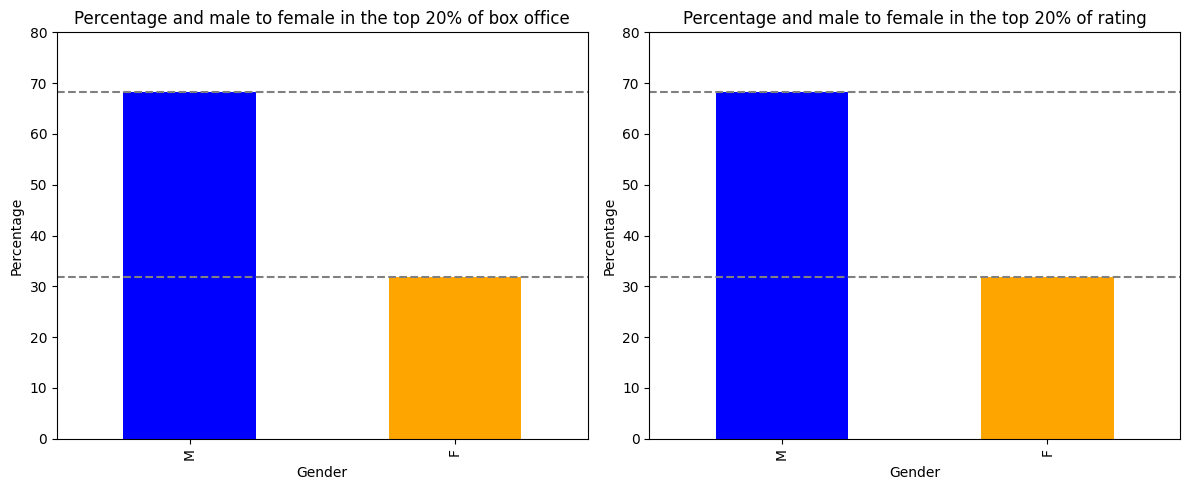

In [36]:
# Calculate the percentage of male to female in the top X% for box office revenue
percentage_male_to_female_BO = top_movies_BO['Actor gender'].value_counts(normalize=True) * 100

#Calculate the percentage of male to female in the top X% for rating
percentage_male_to_female_rating = top_movies_rating['Actor gender'].value_counts(normalize=True) * 100

#P
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

#BO
percentage_male_to_female_BO.plot(kind='bar', ax=axes[0], color=['blue', 'orange'])
axes[0].set_title(f"Percentage and male to female in the top {top}% of box office")
axes[0].set_ylabel("Percentage")
axes[0].set_xlabel("Gender")

#Rating
percentage_male_to_female_rating.plot(kind='bar', ax=axes[1], color=['blue', 'orange'])
axes[1].set_title(f"Percentage and male to female in the top {top}% of rating")
axes[1].set_ylabel("Percentage")
axes[1].set_xlabel("Gender")

#Calculate the maximum value of the 'M' bar in the first plot
max_value_M_BO = percentage_male_to_female_BO['M'].max()

#Draw a horizontal line at the top of the 'M' bar in the first plot
axes[0].axhline(y=max_value_M_BO, color='gray', linestyle='--')
axes[1].axhline(y=max_value_M_BO, color='gray', linestyle='--')

#Calculate the maximum value of the 'M' bar in the first plot
max_value_F_BO = percentage_male_to_female_BO['F'].max()

#Draw a horizontal line at the top of the 'M' bar in the first plot
axes[0].axhline(y=max_value_F_BO, color='gray', linestyle='--')
axes[1].axhline(y=max_value_F_BO, color='gray', linestyle='--')


axes[0].set_ylim(0,80)
axes[1].set_ylim(0,80)
plt.tight_layout()
plt.show()

Here, we considered the complete dataset, extracting data only from the top 20% of movies in each decade to examine the percentage of male and female characters. From this analysis, no noticeable effect is apparent, and the ratio remains similar between financially successful movies and those rated the best.
But we are missing an essential factor, the time periode itself.

We will now examine a similar ratio of male to female characters, but this time considering grouped years. We will continue to focus only on the most successful movies.

In [37]:
#Calculate the percentage of male to female in the top X% for BO, per grouped years
percentage_male_to_female_BO_per_group = top_movies_BO.groupby('Year group')['Actor gender'].value_counts(normalize=True) * 100
#Calculate the percentage of male to female in the top X% for rating, per grouped years
percentage_male_to_female_rating_per_group = top_movies_rating.groupby('Year group')['Actor gender'].value_counts(normalize=True) * 100

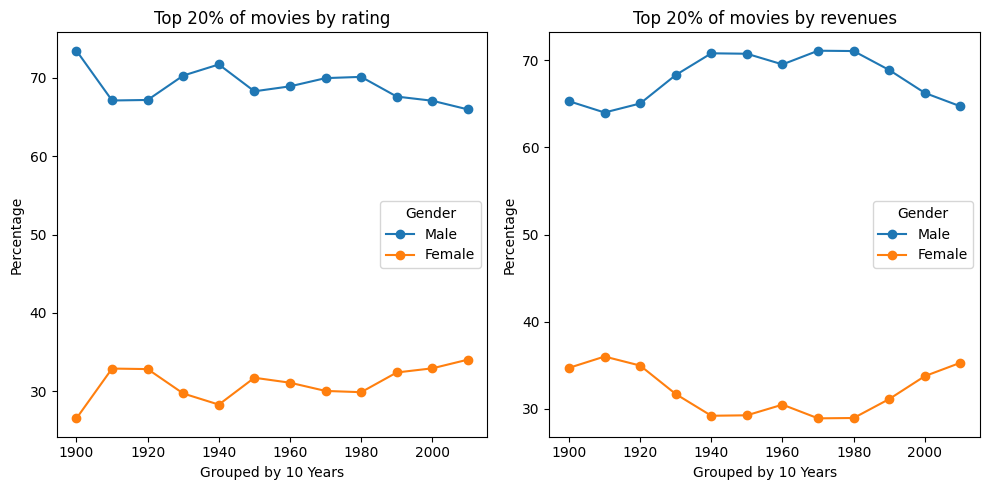

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#Plot for rating
data_m_rating = percentage_male_to_female_rating_per_group.xs('M', level='Actor gender')
data_f_rating = percentage_male_to_female_rating_per_group.xs('F', level='Actor gender')


axs[0].plot(data_m_rating.index, data_m_rating.values, marker='o', label='Male')
axs[0].plot(data_f_rating.index, data_f_rating.values, marker='o', label='Female')
axs[0].set_title(f"Top {top}% of movies by rating")
axs[0].set_ylabel("Percentage")
axs[0].set_xlabel("Grouped by 10 Years")
axs[0].legend(title='Gender')

#Plot for box office
data_m_bo = percentage_male_to_female_BO_per_group.xs('M', level='Actor gender')
data_f_bo = percentage_male_to_female_BO_per_group.xs('F', level='Actor gender')
axs[1].plot(data_m_bo.index, data_m_bo.values, marker='o', label='Male')
axs[1].plot(data_f_bo.index, data_f_bo.values, marker='o', label='Female')
axs[1].set_title(f"Top {top}% of movies by revenues")
axs[1].set_ylabel("Percentage")
axs[1].set_xlabel("Grouped by 10 Years")
axs[1].legend(title='Gender')

plt.tight_layout()
plt.show()

Evaluating the top 20% of movies by decade, we observe a consistent predominance of male characters. Despite fluctuations, the overall pattern indicates a stable representation over time. This sets the stage for more complex analysis, potentially exploring factors influencing these trends.

We will combine these two plots into a single, more information-dense plot. Since the ratio of males to females should always add up to 100%, we can choose to represent just one of the two, setting up both on the same graph for a clearer visual representation.

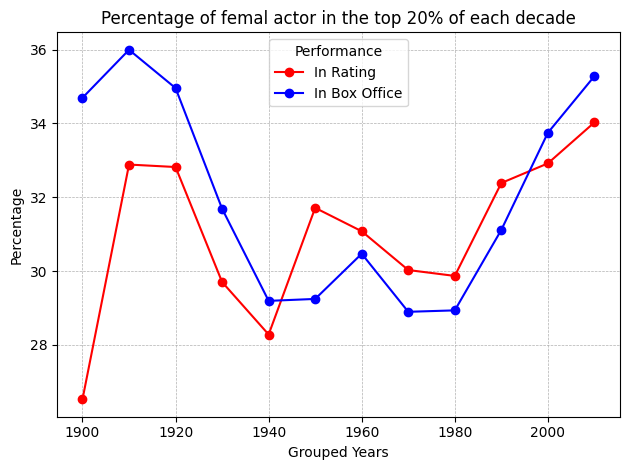

In [39]:
# For the graph that we will include, we don't need to have both male and female since it's just complementary
plt.figure()

# Plot for Rating
plt.plot(data_f_rating.index, data_f_rating.values, marker='o', label='In Rating', color='r')

# Plot for Box Office
plt.plot(data_f_bo.index, data_f_bo.values, marker='o', label='In Box Office', color='b')

plt.title(f"Percentage of femal actor in the top {top}% of each decade")
plt.ylabel("Percentage")
plt.xlabel("Grouped Years")

# Add grid with a darker pastel tone
plt.grid(linestyle='--', linewidth=0.5)

plt.legend(title='Performance', loc='upper center', bbox_to_anchor=(0.5, 1))
plt.tight_layout()  # Adjust layout for better appearance
plt.show()



In delving into the analysis of the top 20% of movies based on both box office revenue and ratings, we discern intriguing trends in female representation across decades. Contrary to the hypothesis that higher-rated movies might exhibit a more diverse cast, our findings indicate that both box office success and high ratings show similar patterns of female participation. Notably, there is a recent uptick in female representation, suggesting a positive trend worth further exploration for those seeking to maximize box office potential without compromising ratings.

Now, considering this ratio in the context of both box office and rating success, the difference in trend is quite subtle, prompting a need for further evaluation. While our primary goal is to achieve the best box office performance, there's room to consider ratings as well. Interestingly, this challenges the hypothesis that movies with better ratings would have a more diverse cast, as the data doesn't strongly support this notion. The recent increase in the percentage of women is a noteworthy development. To stay on the cutting edge of money generation, let's delve deeper into the recent evolution of female representation and seize the opportunity to enhance both profitability and ratings.

## Grouping and time visualisation

This marks the post P2 computation phase. While there may be some overlap with previous computation, this is "new part new me" !

Once again, we'll group years to compare averages in a more meaningful manner. This approach gives rise to a new metric: Performance. Performance evaluates a movie's box office (or rating) in relation to the average for movies within the same year group (decades so far). This metric aims to mitigate the impact of inflation, as well as factors such as the increasing number of ticket sales, providing a more nuanced understanding of a movie's success.

Let's start by looking at this metric overall.

In [40]:
# Calculate percentage of female actors per movie
df_gilles['Percentage of women'] = (df_gilles['Actor gender'] == 'F').groupby(df_gilles['Movie name']).transform('mean') * 100

# Calculate average BO and rating for each movie's grouped year
average_box_office_per_group = df_gilles.groupby('Year group')['Movie box office revenue'].transform('mean')
average_rating_per_group = df_gilles.groupby('Year group')['Average rating'].transform('mean')

# Compare each movie's performance to the average of its year group
df_gilles['Performance vs average BO'] = (df_gilles['Movie box office revenue'] / average_box_office_per_group - 1) * 100
df_gilles['Performance vs average rating'] = (df_gilles['Average rating'] / average_rating_per_group - 1) * 100

groupe_size=5
# Create groups of percentage of women. Else if we would have some weird continum and high variation since there are few movies with 4.37% women as exemple
bins = np.arange(0, 101, groupe_size)
df_gilles['Percentage of women group'] = pd.cut(df_gilles['Percentage of women'], bins, labels=False) * groupe_size

# Calculate average performance for each group
average_performance = df_gilles.groupby('Percentage of women group')[['Performance vs average BO', 'Performance vs average rating']].mean()

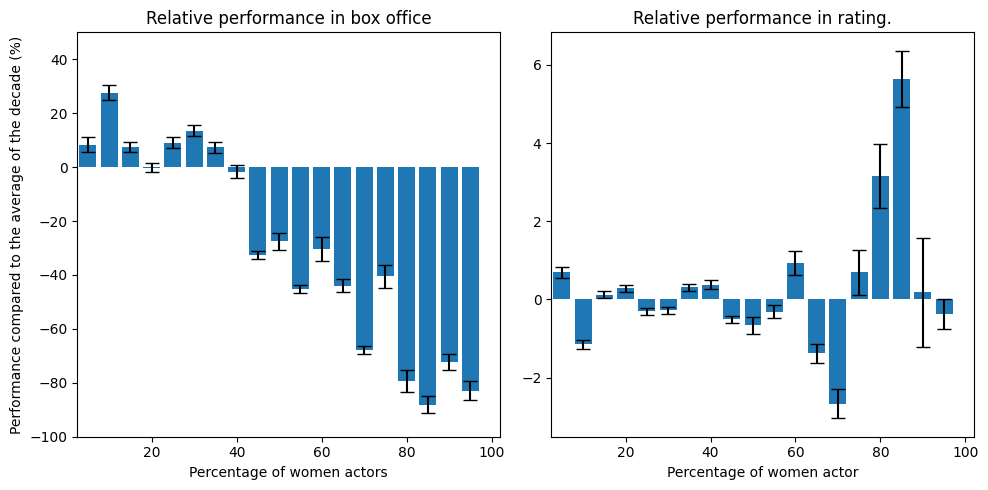

In [41]:
# Calculate the standard error of the mean for each group
sem_performance = df_gilles.groupby('Percentage of women group')[['Performance vs average BO', 'Performance vs average rating']].sem()

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(
    average_performance.index,
    average_performance['Performance vs average BO'],
    yerr=sem_performance['Performance vs average BO'],
    capsize=5,
    width=4
)
plt.title('Relative performance in box office')
plt.xlabel('Percentage of women actors')
plt.ylabel('Performance compared to the average of the decade (%)')
plt.xlim(left=2.5)
plt.ylim(-100, 50)

plt.subplot(1, 2, 2)
plt.bar(
    average_performance.index,
    average_performance['Performance vs average rating'],
    yerr=sem_performance['Performance vs average rating'],
    capsize=5,
    width=4
)
plt.title('Relative performance in rating.')
plt.xlabel('Percentage of women actor')
#plt.ylabel('Performance compared to the average of the decade (%)')
plt.xlim(left=2.5)

plt.tight_layout()
plt.show()

The dataset uncovers a significant decline in box office performance when movies feature more than 40% female actors, in stark contrast to rating performance, which maintaining a small range of around 5% in performance difference. Historically, movies with fewer female actors tended to outperform financially. However, as industry trends undergo a rapid evolution, it's crucial to consider both current and future implications..

While the primary focus is on box office success, it appears that gender has a limited effect on our movie ratings. Based on these analyses, historical data suggests that a lower percentage of women in movies yielded the best financial results. However, recognizing the changing landscape, let's delve into the evolution of these trends and ensure to keep up with recent trend to avoid potential missteps.

In [42]:
# Animated plot have feelings, and it keeps failing. Let's make a new, clean, datafram with only the thing that matter to avoid any major mistake.
df_gilles_reset = df_gilles.reset_index()
new_df = df_gilles_reset[['Year group', 'Percentage of women group', 'Performance vs average BO', 'Performance vs average rating']]
new_df.dropna()
new_df = new_df.groupby(['Year group', 'Percentage of women group']).mean().reset_index()

In [43]:
# Remove the rows where 'Year group' is 1880 or 1890. There are so few data and it's really not needed
new_df = new_df[~new_df['Year group'].isin([1880, 1890])]

# Group by 'Year group' and 'Percentage of Women Group', then calculate the mean
grouped_df = new_df.groupby(['Year group', 'Percentage of women group']).mean().reset_index()

# Get sorted unique years
years = sorted(grouped_df['Year group'].unique())

# Create a figure with subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('Relative performance in revenue', 'Relative performance in rating'))

# Set the initial Y axis ranges. So it does not change everytime we slide
bo_range = [-100, 100]
rating_range = [-15, 15]

# Define the initial year for the bar traces
initial_year = years[0]

# Add bar traces for the initial year to set up the figure
fig.add_trace(
    go.Bar(x=grouped_df[grouped_df['Year group'] == initial_year]['Percentage of women group'],
           y=grouped_df[grouped_df['Year group'] == initial_year]['Performance vs average BO'],
           name='Performance vs average BO'),
    row=1, col=1
)
fig.add_trace(
    go.Bar(x=grouped_df[grouped_df['Year group'] == initial_year]['Percentage of women group'],
           y=grouped_df[grouped_df['Year group'] == initial_year]['Performance vs average rating'],
           name='Performance vs average rating'),
    row=1, col=2
)

# Create the frames for the animation
frames = []
for year in years:
    frame = go.Frame(
        data=[
            go.Bar(x=grouped_df[grouped_df['Year group'] == year]['Percentage of women group'],
                   y=grouped_df[grouped_df['Year group'] == year]['Performance vs average BO']),
            go.Bar(x=grouped_df[grouped_df['Year group'] == year]['Percentage of women group'],
                   y=grouped_df[grouped_df['Year group'] == year]['Performance vs average rating'])
        ],
        name=str(year)
    )
    frames.append(frame)

fig.frames = frames

# Create the slider
sliders = [{
    'steps': [
        {
            'method': 'animate',
            'label': str(year),
            'args': [[str(year)], {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate'}]
        } for year in years
    ]
}]

fig.update_layout(
    showlegend=False,  # This hides the legend
    sliders=sliders

)

# Set the X axis range to be between 0 and 100 and add title for both subplots
fig.update_xaxes(range=[0, 100], title_text='Percentage of woman actor (%)', row=1, col=1)
fig.update_xaxes(range=[0, 100], title_text='Percentage of woman actor (%)', row=1, col=2)

# Set the Y axis range
fig.update_yaxes(range=bo_range, title_text='Performance compared to the average revenue (%)', row=1, col=1)
fig.update_yaxes(range=rating_range, title_text='Performance compared to the average rating (%)', row=1, col=2)

# Saving the figure
#fig.write_html("./plots/gilles_dynamic.html")

# Show the figure
fig.show()

In this decade by decade interactive visualisation, we can observe a bit of nuance on the data that we had over the entire dataset. The data consistently reveals that the percentage of female actors has historically had and continues to have a limited impact on ratings. For revenue, however, the trend is quite different. Although the effects become less extreme with a higher proportion of women (as long as it remains close to 50%), it still appears that, to maximize profit, even in the most recent years, a focus on a higher proportion of male actors is advisable.

As the film industry undergoes transformations, there's evidence to suggest that this trend is waning, signaling a move towards a more equitable gender representation. We need to acknowledge the rapidly changing times, and it may be prudent to seek more recent data to stay on the cutting edge of box office dynamics. However, current indications suggest that maintaining a lower percentage of female actors remains a more lucrative approach for revenue maximization in the film industry.

# Influence of actors' fame on financial performance

In [44]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Reload the dataset:

In [45]:
characters_movies = pickle.load(open('data/characters_movies_df_pickle', 'rb'))

We want to quantify the actors' fame in some way. We decided to consider actor's career span, number of movies they starred in, average box office revenue and the average rating of movies they appeared in. Let's delve right in.

In this segment, we are creating a new data frame that focuses on key information about each actor. Initially, we remove any instances of NaN values to ensure the accuracy of our data. The primary columns of this data frame grouped by actors include the average Weighted Rating, Number of Movies, Years of Casting, and Average Box Office.

The Weighted Rating column is particularly insightful as it considers the Average Rating of the IMDb dataset weighted by the number of votes, thus providing a more comprehensive view of their acclaim. To compute the Years of Casting for each actor, we determine the span of their career by subtracting the year of their last movie from the year of their first movie. This approach gives us a reliable duration of each actor active years in the film industry.

### Setting data-frame for actors

In [46]:
ratings_df = characters_movies[['Actor name','Movie name','Average rating','Number of votes','Inflation-adjusted box office revenue','Movie release year']].dropna()

# weighted average ratings
ratings_df['Weighted Rating'] = ratings_df['Average rating']*ratings_df['Number of votes']
ratings_df['First movie year'] = ratings_df['Movie release year']
ratings_df['Last movie year'] = ratings_df['Movie release year']

#group by actor name and having sums of weighted ratings and number of votes (calcluate it same as for credits at epfl)
actor_grouped = ratings_df.groupby('Actor name').agg({
    'Weighted Rating': 'sum',
    'Number of votes': 'sum',
    'Movie name': 'nunique',
    'Inflation-adjusted box office revenue': 'mean',
    'First movie year': 'min',
    'Last movie year': 'max',
})

actor_grouped.rename(columns={'Movie name': 'Number of movies'}, inplace=True)
actor_grouped.rename(columns={'Inflation-adjusted box office revenue': 'Average Box Office'}, inplace=True)

actor_grouped['Years of casting'] = actor_grouped['Last movie year'] - actor_grouped['First movie year'] + 1
actor_grouped['Weighted Rating'] = actor_grouped['Weighted Rating'] / actor_grouped['Number of votes']

## Linear regression plots for each variable

In this analysis, we are exploring the relationships between different actor-centric metrics and their films' average box office revenues using scatter plots and statistical correlation analysis.These visualizations and statistical analyses help us understand the relationships between the number of movies an actor has done, their active years in the industry, their weighted rating, with their movies' average box office revenues. The Pearson correlation coefficients provide a quantifiable measure of how these factors are related, although it's important to note that a correlation does not imply causation. We'll look at the p-value, which will help us understand if the link we see in our data is meaningful or just happened by chance.

PearsonRResult(statistic=0.032125053407823866, pvalue=1.7528742475604377e-09)


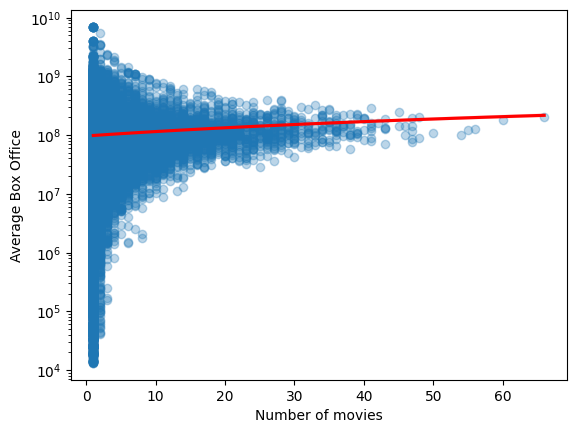

In [47]:
#plotting number of movies vs average box office with a logarithmic y-scale and a red regression line
plt.scatter(x=actor_grouped['Number of movies'], y=actor_grouped['Average Box Office'], alpha=0.3)
plt.yscale('log')
plt.ylabel('Average Box Office Revenue (Log Scale)')
plt.xlabel('Normalized Number of Movies')
sns.regplot(x='Number of movies', y='Average Box Office', data=actor_grouped, scatter=False, line_kws={'color': 'red'})
print(scipy.stats.pearsonr(actor_grouped['Number of movies'],actor_grouped['Average Box Office']))
plt.show()

PearsonRResult(statistic=0.04242100312382629, pvalue=1.867393843020782e-15)


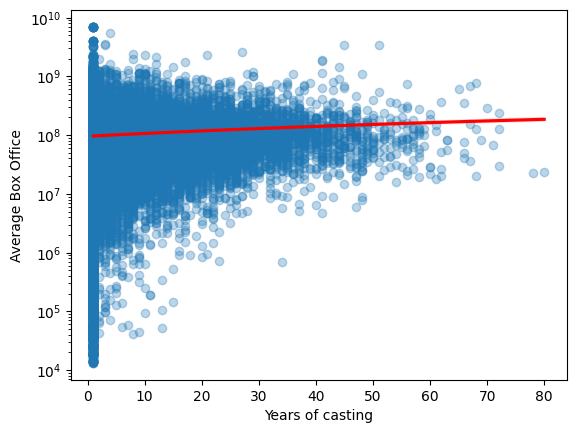

In [48]:
actor_grouped['Years of casting'] = actor_grouped['Years of casting'].astype(float)
actor_grouped['Average Box Office'] = actor_grouped['Average Box Office'].astype(float)

#replotting years of casting vs average box office
plt.scatter(x=actor_grouped['Years of casting'], y=actor_grouped['Average Box Office'], alpha=0.3)
plt.yscale('log')
plt.ylabel('Average Box Office Revenue (Log Scale)')
plt.xlabel('Normalized Years of Casting')
sns.regplot(x='Years of casting', y='Average Box Office', data=actor_grouped, scatter=False, line_kws={'color': 'red'})
print(scipy.stats.pearsonr(actor_grouped['Years of casting'],actor_grouped['Average Box Office']))
plt.show()

PearsonRResult(statistic=0.18350514306335214, pvalue=2.324888511414724e-263)


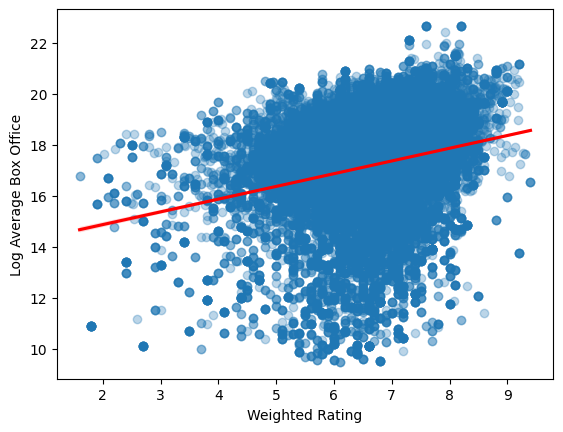

In [49]:
#applying logarithmic transformation to 'average box office' for the regression
actor_grouped['Weighted Rating'] = actor_grouped['Weighted Rating'].astype(float)
actor_grouped['Log Average Box Office'] = np.log(actor_grouped['Average Box Office'])

#replotting weighted rating vs log-transformed average box office
plt.scatter(x=actor_grouped['Weighted Rating'], y=actor_grouped['Log Average Box Office'], alpha=0.3)
plt.ylabel('Log of Average Box Office Revenue')
plt.xlabel('Normalized Weighted Rating')
sns.regplot(x='Weighted Rating', y='Log Average Box Office', data=actor_grouped, scatter=False, line_kws={'color': 'red'})
print(scipy.stats.pearsonr(actor_grouped['Weighted Rating'],actor_grouped['Average Box Office']))
plt.show()

In summary, we see for each graph that the Pearson correlation coefficients in all three cases indicate weak to modest relationships, the very small p-values consistently point to these relationships being statistically significant. This means that despite the low strength of the linear correlations, the relationships between these variables are consistent and unlikely to be due to random fluctuations in the data. Overall, an increased number of movies or a longer cinematographic career translate to movies with higher box office revenues. As expected, higher ratings translates to higher box office revenues on average.

## Performing a PCA to check which variable contains the highest variance

This code performs Principal Component Analysis, focusing on the three key variables. The process starts by normalizing these variables to ensure each one has equal weight in the analysis.

The code calculates the explained variance ratio for each of these components, indicating how much of the total variance in the data each component accounts for. It also determines the absolute values of the coefficients for the first principal component. These coefficients show how much each original variable contributes to this principal component, revealing which variables are most influential.

In [50]:
#normalizing the data for each variable
scaler = StandardScaler()
#selecting the three variables for pca
pca_data = actor_grouped[['Weighted Rating', 'Years of casting', 'Number of movies']]

#normalizing the data
pca_data_normalized = scaler.fit_transform(pca_data)

#performing pca
pca = PCA(n_components=3)
pca.fit(pca_data_normalized)

#getting the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

#getting the absolute values of the coefficients of the first principal component
component_1_coefficients = abs(pca.components_[0])

#mapping coefficients back to the original variables
variable_contribution = dict(zip(pca_data.columns, component_1_coefficients))

print(f'The variance ratio of 3 new principal components are {explained_variance_ratio}')
print(f'The variances of the first principal component of each normalized variables are{variable_contribution}')


The variance ratio of 3 new principal components are [0.58054305 0.31099475 0.1084622 ]
The variances of the first principal component of each normalized variables are{'Weighted Rating': 0.28840984449418394, 'Years of casting': 0.6789111563654053, 'Number of movies': 0.6752032311544639}


## $R^2$ values:

The next code calculates the coefficient of determination, denoted as R², for each model. This is a statistical measure that represents the proportion of the variance in a dependent variable which is Average Box office revenue, that is predictable from an independent variable. In our case, there are only 3 features to consider.

These values help us understand the effectiveness of each actor-centric metric ('Weighted Rating', 'Years of Casting', 'Number of Movies') in predicting the average box office revenue. A higher R² value suggests a stronger relationship between the independent variable and the average box office revenue.

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#assuming 'actor_grouped' is your dataframe
X_weighted_rating = actor_grouped[['Weighted Rating']]
X_years_casting = actor_grouped[['Years of casting']]
X_number_movies = actor_grouped[['Number of movies']]
y = actor_grouped['Average Box Office']

#fit linear regression models
model_weighted_rating = LinearRegression().fit(X_weighted_rating, y)
model_years_casting = LinearRegression().fit(X_years_casting, y)
model_number_movies = LinearRegression().fit(X_number_movies, y)

#calculate r² values
r2_weighted_rating = model_weighted_rating.score(X_weighted_rating, y)
r2_years_casting = model_years_casting.score(X_years_casting, y)
r2_number_movies = model_number_movies.score(X_number_movies, y)

#output the r² values
print("R² for Weighted Rating:", r2_weighted_rating)
print("R² for Years of Casting:", r2_years_casting)
print("R² for Number of Movies:", r2_number_movies)


R² for Weighted Rating: 0.033674137530701365
R² for Years of Casting: 0.0017995415060315656
R² for Number of Movies: 0.0010320190564555576


In summary, all three R² values are quite low, suggesting that none of these individual metrics are strong predictors of an actor's average box office revenue when considered independently. This highlights the complexity of identifying box office success predictors, successes which are likely influenced by a multitude of factors beyond these individual metrics.

## CCDF


In many real-world datasets, especially those related to social phenomena like movie industry data, the distribution of values can be heavy-tailed. This means that a large proportion of the data points are gathered in the lower range (like actors with few movies), but there's a long tail in the distribution representing significant cases (like actors with many movies). Standard statistical methods might not effectively capture the characteristics of such distributions.

The use of logarithmic scaling in the y-axis ('log' scale) helps in better visualizing and interpreting data that spans several orders of magnitude, which is often the case with heavy-tailed distributions.

In [52]:
def plot_ccdf(data, title, xlabel):
    sorted_data = np.sort(data)
    ccdf = 1. - np.arange(1, len(sorted_data) + 1) / len(sorted_data)

    plt.figure(figsize=(6, 5))
    plt.plot(sorted_data, ccdf, color='blue', lw=2)
    plt.xlabel(xlabel)
    plt.ylabel('CCDF')
    plt.title(title)
    plt.grid(True)
    #plt.xscale('log')
    plt.yscale('log')
    plt.show()

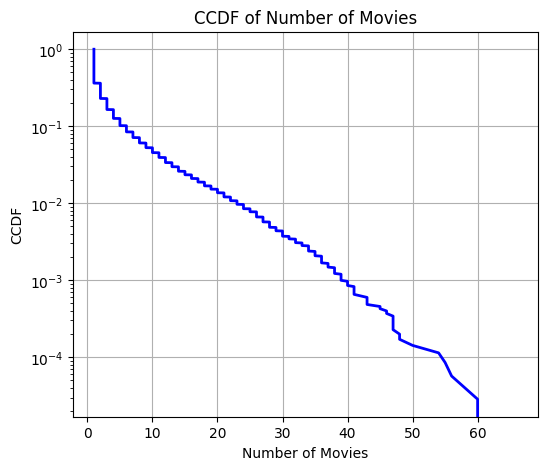

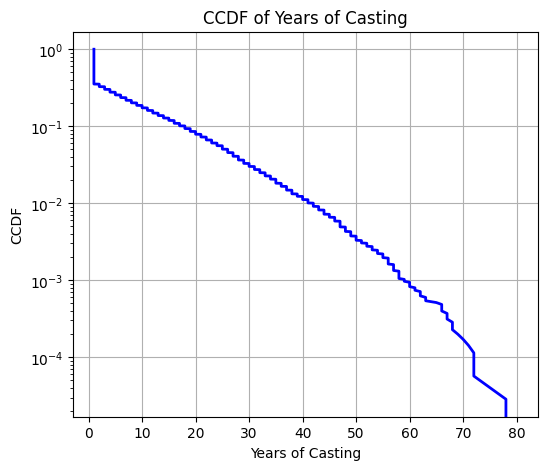

In [53]:
plot_ccdf(actor_grouped['Number of movies'], 'CCDF of Number of Movies', 'Number of Movies')
plot_ccdf(actor_grouped['Years of casting'], 'CCDF of Years of Casting', 'Years of Casting')

In both cases, the CCDF plots shows a linear trend in the logscale plot, which is typical of heavy-tailed distributions. This fact will have to be taken into account when we divide the data into sets of similar sizes.

## Histograms
In this section, our objective is to illustrate the density distribution of box office revenues divided into different sets of aggregated number of movies an actor has participated in.

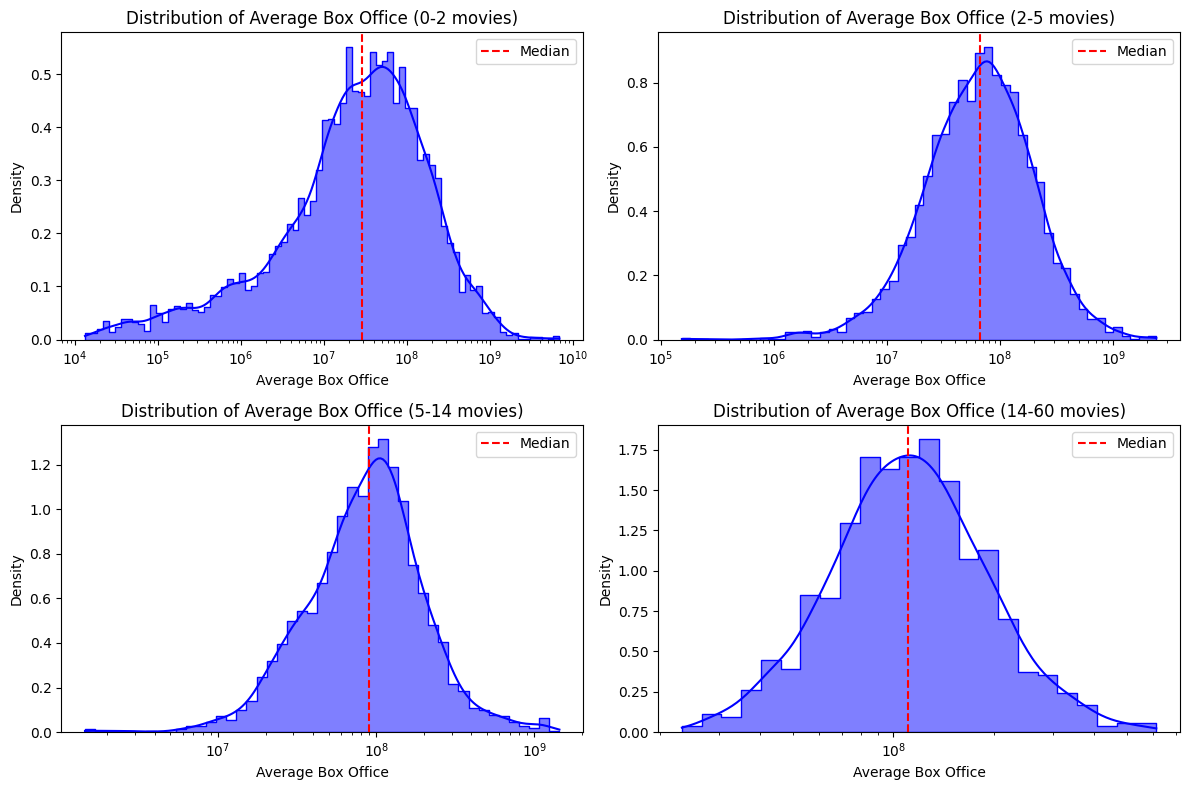

In [54]:
# Define the bins and labels
bins = [0, 2, 5, 14, 60]
labels = ['0-2', '2-5', '5-14', '14-60']
actor_grouped['Movie Group'] = pd.cut(actor_grouped['Number of movies'], bins=bins, labels=labels, right=True)

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Modified loop to plot on subplots
for i, label in enumerate(labels):
    group_data = actor_grouped[actor_grouped['Movie Group'] == label]['Average Box Office']
    sns.histplot(group_data, ax=axes[i], kde=True, color='blue', element='step', stat='density', log_scale=True)
    axes[i].axvline(group_data.median(), color='red', linestyle='--', label=f'Median')
    axes[i].set_title(f"Distribution of Average Box Office ({label} movies)")
    axes[i].set_xlabel('Average Box Office')
    axes[i].set_ylabel('Density')
    axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

The plots clearly show a shift of the distribution the right of the average box office when considering groups of increasing filmography volumes. The next step is to verify scientificaly, with the help of hypothesis testing, if actors with higher number of movies indeed feature in financially more successful movies.

To do so, let's first divide the dataset into two groups of similar sizes and plot their average box office distributions.

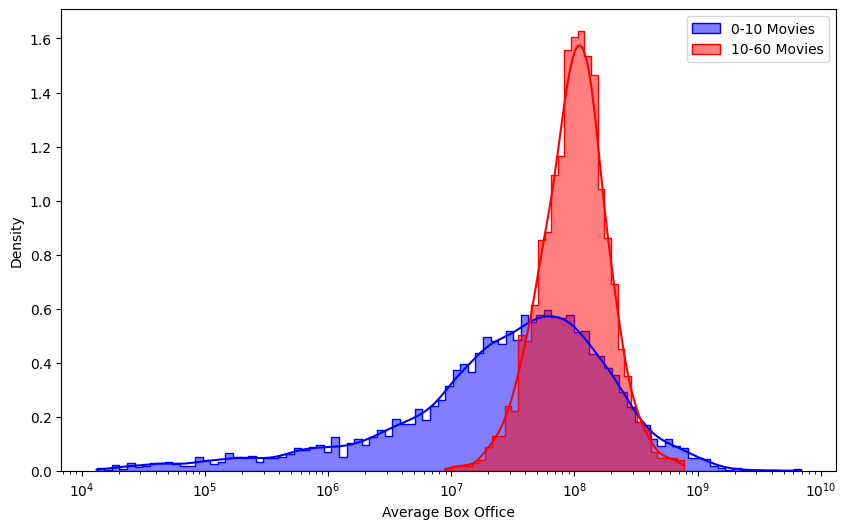

In [55]:
# divide the data in 2 groups of a similar size
group1 = actor_grouped[actor_grouped['Number of movies'] < 10]['Average Box Office']
group2 = actor_grouped[actor_grouped['Number of movies'] >= 10]['Average Box Office']

plt.figure(figsize=(10, 6))
sns.histplot(group1, label='0-10 Movies', kde=True, color='blue', element='step', stat='density', log_scale=True)
sns.histplot(group2, label='10-60 Movies', kde=True, color='red', element='step', stat='density', log_scale=True)
plt.legend()
plt.show()

## Hypothesis testing

Then, the t-test enables us to check if there's a noticable difference in the distribution of revenues from two groups of actors defined previously. The first group includes actors who have been in 0 to 10 movies, and the second group consists of actors who have been in 10 to 60 movies. Following this, the code creates a plot showing the average box office earnings for each group. Alongside these averages, it also displays their 95% confidence intervals.

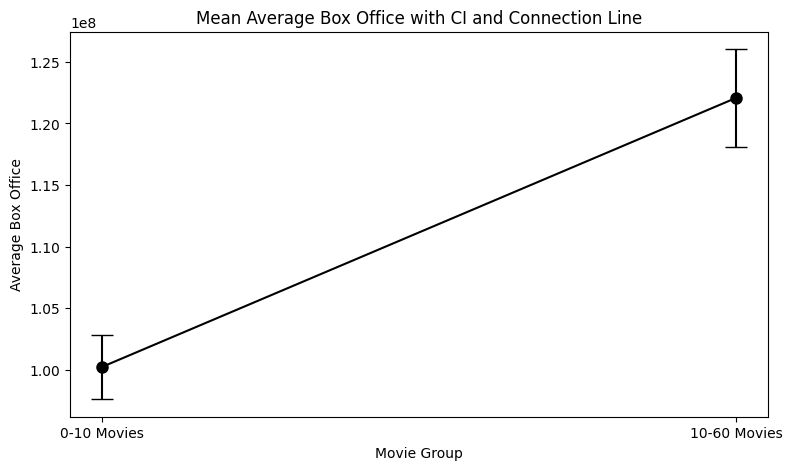

T-statistic: -9.023753739035936, P-value: 2.831295797271695e-19


In [56]:
from scipy.stats import ttest_ind

plt.figure(figsize=(9, 5))

x_labels = ['0-10 Movies', '10-60 Movies']

# mean and margin of error for the confidence intervals of the two groups
means = [np.mean(group1),np.mean(group2)]
errors = [1.96*np.std(group1, ddof=1) / np.sqrt(len(group1.dropna())),
          1.96*np.std(group2, ddof=1) / np.sqrt(len(group2.dropna()))]

# plot of the confidence interval
plt.errorbar(x_labels, means, yerr=errors,
             fmt='o', markersize=8, capsize=8, color='black', label='95% Confidence interval')

#black line connecting the means
plt.plot([0, 1], [means[0], means[1]], color='black', marker='o')

plt.title('Mean Average Box Office with CI and Connection Line')
plt.xlabel('Movie Group')
plt.ylabel('Average Box Office')
plt.show()

t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
#print(f"T-test between groups {group1} and {group2}:")
print(f"T-statistic: {t_stat}, P-value: {p_val}")

The magnitude of the T-statistic is quite large, suggesting a significant difference between the two groups. In other words, the larger the absolute value of the T-statistic, the greater the evidence against the null hypothesis, which states that there is no difference between the groups.

The P-value being extremely small (in this case, approximately 2.83e-19) is a strong indication to reject the null hypothesis meaning there is indeed a strong implied difference for actors with higher number of movies featured in.

## Animation for the ratings

In this interactive figure, each position of the slider corresponds to a different movie group, enabling users to observe not only how the density of average box office revenue varies but also the distribution of weighted average ratings within each group. This dual focus on both average box office revenue and weighted ratings offers a comprehensive view of an actor's filmography.

In [57]:
import plotly.figure_factory as ff

# Create a figure with a slider
fig = go.Figure()

steps = []
# Add traces for each label
for i,label in enumerate(labels):
    group_data = actor_grouped[actor_grouped['Movie Group'] == label]['Weighted Rating']
    median = group_data.median()

    visible = True if label == labels[0] else False
    # Add the histogram corresponding to the label
    fig.add_trace(
        go.Histogram(
            x=group_data,
            name=f"{label} movies",
            xbins=dict(
                start=0,
                end=10,
                size=0.05
            ),
            marker=dict(color='blue'),
            opacity=0.5,
            showlegend=False,
            visible=visible,
            histnorm='probability'
        )
    )

    # Create a list of steps for the slider
    step = dict(
        method="update",
        args=[{"visible": [False] * len(labels)},
              {"title": f"Distribution of Average Box Office ({label} movies)"}],
        label=label
    )
    step["args"][0]["visible"][i] = True
    steps.append(step)

# Create and add slider
sliders = [dict(
    active=0,
    currentvalue={"prefix": "Movie Group: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    xaxis_title='Average Rating',
    yaxis_title='Density',
    title="Distribution of Average Box Office",
    bargap=0.1
)

fig.show()

## Compare distribution of Box offices for actors with different Carreer lengths

 This code is used to analyze and visualize how the average box office revenue distribution varies across actors with different lengths of careers in the film industry. By dividing the actors into groups based on their years of casting and examining the distribution within each group, the code offers insights into the relationship between an actor's career longevity and their movies' financial success.

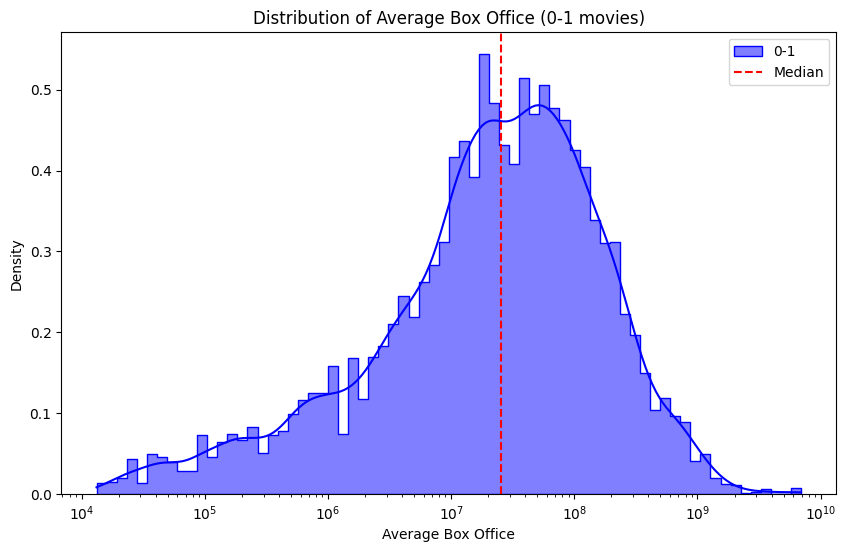

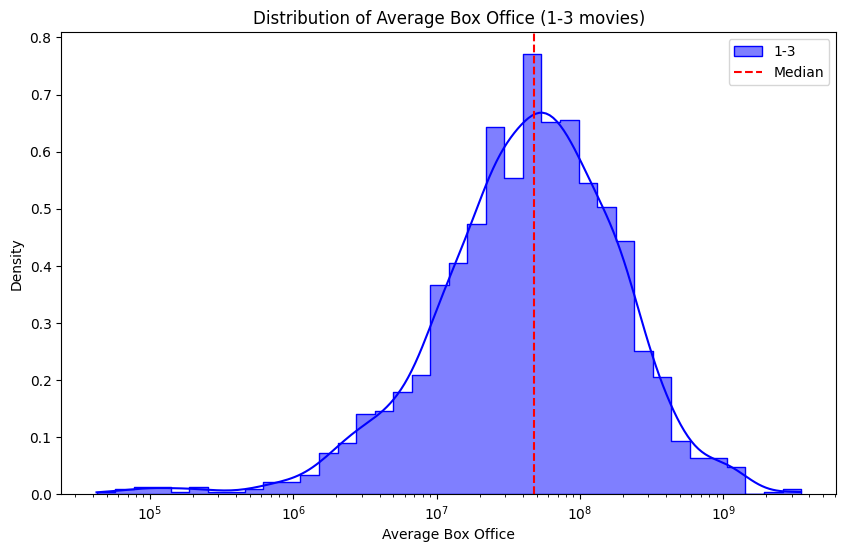

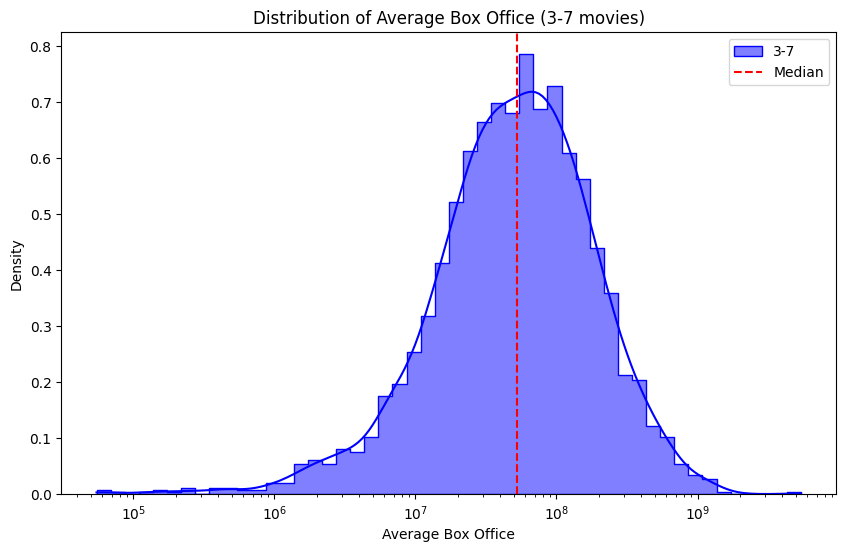

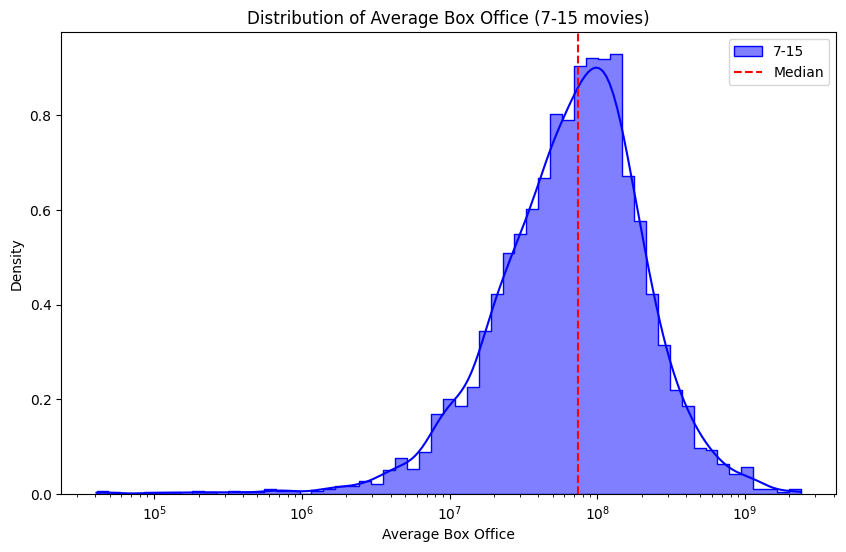

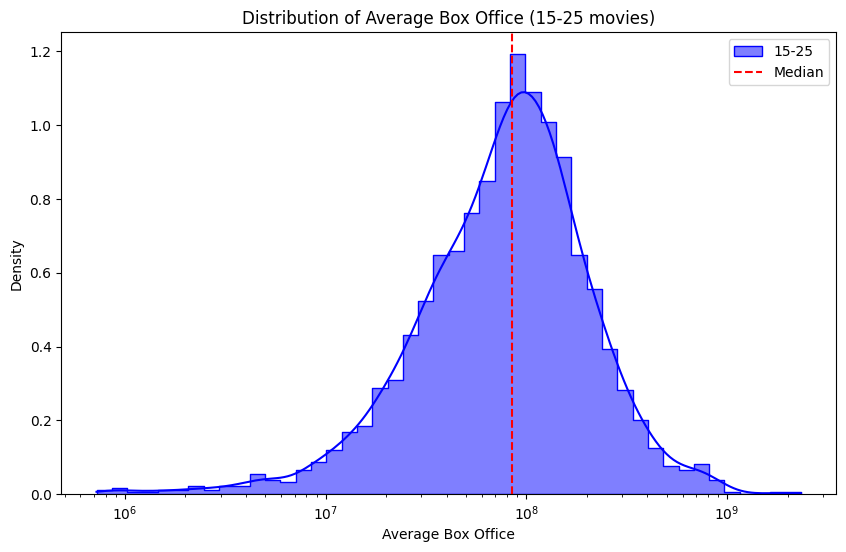

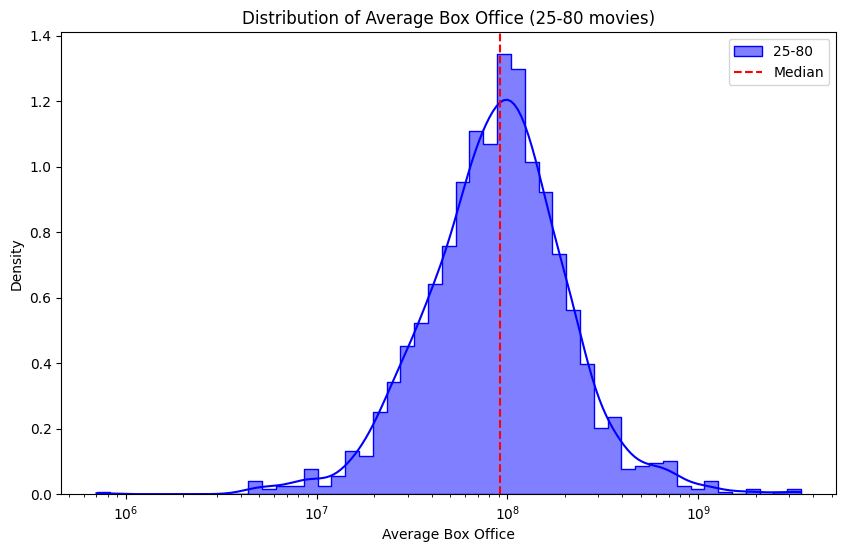

In [58]:
#adjusting the bins and labels for 'years of casting'
bins = [0, 1, 3, 7, 15, 25, 80]
labels = ['0-1', '1-3', '3-7', '7-15', '15-25', '25-80']
actor_grouped['Years of Casting Group'] = pd.cut(actor_grouped['Years of casting'], bins=bins, labels=labels, right=True)

# Modified function to plot distribution for all the bins
for label in labels:
  plt.figure(figsize=(10, 6))
  group_data = actor_grouped[actor_grouped['Years of Casting Group'] == label]['Average Box Office']
  sns.histplot(group_data, label=label, kde=True, color='blue', element='step', stat='density', log_scale=True)
  plt.axvline(group_data.median(), color='red', linestyle='--', label=f'Median')
  plt.title(f"Distribution of Average Box Office ({label} movies)")
  plt.xlabel('Average Box Office')
  plt.ylabel('Density')
  plt.legend()
  plt.show()

Similarly to the previous case with the number of movies, we divide the data in 2 groups, plot their revenue distibution and test the null hypothesis

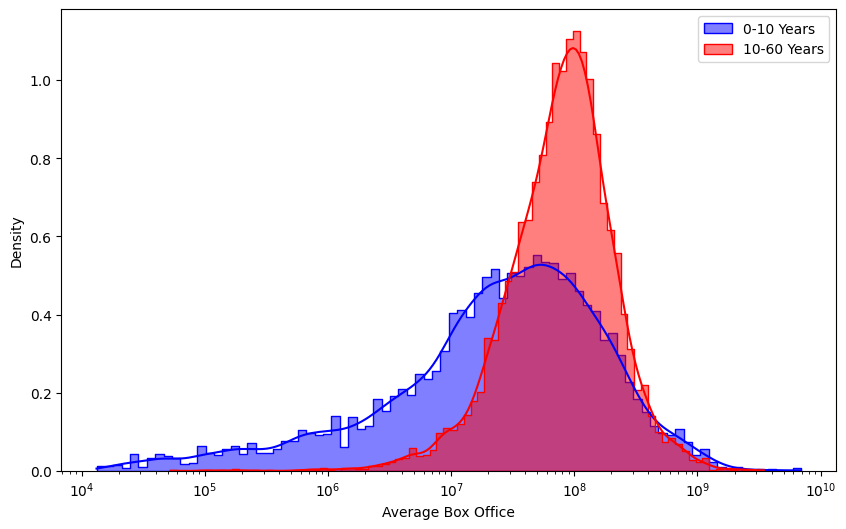

In [59]:
# divide the data in 2 groups of similar sizes
group1 = actor_grouped[actor_grouped['Years of casting'] < 10]['Average Box Office']
group2 = actor_grouped[actor_grouped['Years of casting'] >= 10]['Average Box Office']

plt.figure(figsize=(10, 6))
sns.histplot(group1, label='0-10 Years', kde=True, color='blue', element='step', stat='density', log_scale=True)
sns.histplot(group2, label='10-60 Years', kde=True, color='red', element='step', stat='density', log_scale=True)
plt.legend()
plt.show()

In this case, the t-test is performed to determine if there's a significant difference in average values between two groups of actors, divided based on their years of casting. One group comprises actors with shorter casting durations (0 to 10 years), while the other includes those with longer casting spans (10 to 60 years). Along with these averages, the plot also features their 95% confidence intervals.

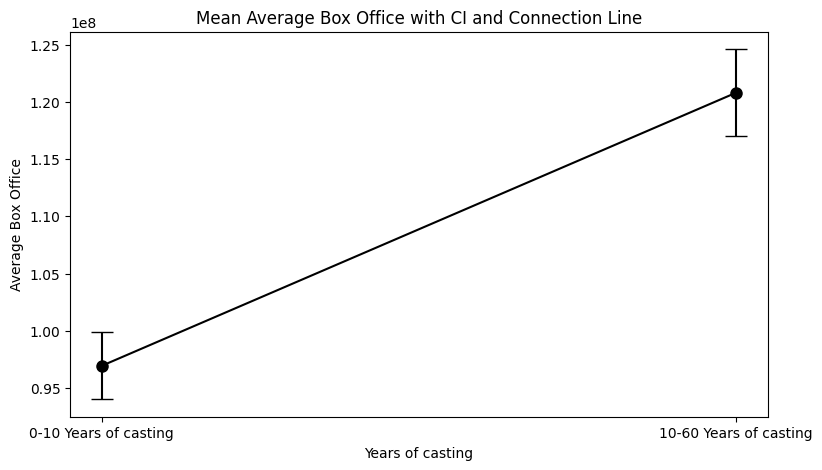

T-statistic: -9.742098965082361, P-value: 2.315101543205186e-22


In [60]:
from scipy.stats import ttest_ind

plt.figure(figsize=(9, 5))

x_labels = ['0-10 Years of casting', '10-60 Years of casting']

# mean and margin of error for the confidence intervals of the two groups
means = [np.mean(group1),np.mean(group2)]
errors = [1.96*np.std(group1, ddof=1) / np.sqrt(len(group1.dropna())),
          1.96*np.std(group2, ddof=1) / np.sqrt(len(group2.dropna()))]

# plot of the confidence interval
plt.errorbar(x_labels, means, yerr=errors,
             fmt='o', markersize=8, capsize=8, color='black', label='95% Confidence interval')

#black line connecting the means
plt.plot([0, 1], [means[0], means[1]], color='black', marker='o')

plt.title('Mean Average Box Office with CI and Connection Line')
plt.xlabel('Years of casting')
plt.ylabel('Average Box Office')
plt.show()

t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
#print(f"T-test between groups {group1} and {group2}:")
print(f"T-statistic: {t_stat}, P-value: {p_val}")

The results are inherently very similar to the previous case with the number of movies and we can again reject the null hypothesis with a strong confidence

## Compare distribution of Box offices with different average movie ratings

Here, we analyze and try to quantify the relationship between rating and revenues. Although the following graph is not very informative in itself since the correlation between ratings and adjusted revenues seems obvious, it still confirms the idea that movies with higher revenues score higher ratings.

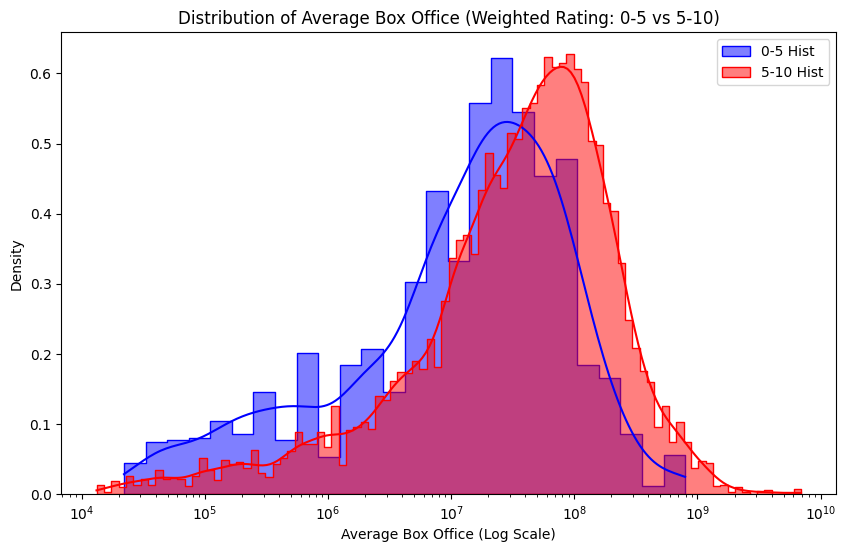

T-test between groups 0-5 and 5-10:
T-statistic: -24.69935971033816, P-value: 3.392237656998047e-125


In [61]:
rating_bins = [0, 5, 10]
rating_labels = ['0-5', '5-10']

actor_grouped['Rating Group'] = pd.cut(actor_grouped['Weighted Rating'], bins=rating_bins, labels=rating_labels, right=False)


def plot_hist_kde_log_scale_weighted_rating(data, group1, group2, title):
    plt.figure(figsize=(10, 6))

    # Histogram and KDE for group1
    sns.histplot(data[data['Rating Group'] == group1]['Average Box Office'], label=f'{group1} Hist', kde=True, color='blue', element='step', stat='density', log_scale=True)

    # Histogram and KDE for group2
    sns.histplot(data[data['Rating Group'] == group2]['Average Box Office'], label=f'{group2} Hist', kde=True, color='red', element='step', stat='density', log_scale=True)

    plt.title(title)
    plt.xlabel('Average Box Office (Log Scale)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Perform the t-test and print the results
    group1_data = data[data['Rating Group'] == group1]['Average Box Office']
    group2_data = data[data['Rating Group'] == group2]['Average Box Office']
    t_stat, p_val = ttest_ind(group1_data, group2_data, equal_var=False)  # Welch's t-test
    print(f"T-test between groups {group1} and {group2}:")
    print(f"T-statistic: {t_stat}, P-value: {p_val}")



plot_hist_kde_log_scale_weighted_rating(actor_grouped, '0-5', '5-10', 'Distribution of Average Box Office (Weighted Rating: 0-5 vs 5-10)')

# Topic analysis and extraction of movie themes

In [62]:
import gensim
from collections import defaultdict
from gensim import corpora
from gensim.models import TfidfModel

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [63]:
from nlp_word_extraction import load_summaries

In [64]:
DATA_PATH = 'data/MovieSummaries/'
SPACY_PATH = 'spacy_results'
LDA_PATH = 'lda_models'

Load summaries:

In [65]:
summaries = load_summaries(os.path.join(DATA_PATH, 'plot_summaries.txt'))
summaries['MovieID'] = summaries['MovieID'].astype('int64')

Summaries is a DataFrame object with first column which represents a movie id and a second column which contains movie summaries.

### Loading the data from NLP anaysis

The NLP task was done earlier and results were saved with `pickle`. Extraction of words based on their POS was done using `spacy` module, since it had NER in its pipeline, which allowed the removal of names. In the first iteration, words were extracted using `nltk` and the set of nouns turned out to be severely polluted by character names. Though LDA found the names to be an important predictor to determine film's topics, they do not carry much information about the ideas in the film. That is why we opted to remove them from the set.

Since this step of the process takes about ~40 minutes, and is unlikely to change during the work on the process, we opted to do it once and save the results using `pickle`. The program `nlp_word_extraction.py` contains the code used for word extraction.

Load dictionaries with extracted nouns, verbs and descriptions (adverbs and adjectives):

In [66]:
with open(os.path.join(SPACY_PATH, 'nouns.pickle'), 'rb') as handle:
    nouns = pickle.load(handle)

with open(os.path.join(SPACY_PATH, 'verbs.pickle'), 'rb') as handle:
    verbs = pickle.load(handle)

with open(os.path.join(SPACY_PATH, 'descs.pickle'), 'rb') as handle:
    descs = pickle.load(handle)

We construct a new dictionary, containing nouns, verbs and descriptors. It will then be used for LDA analysis.

In [67]:
all_words = {}
for key in nouns.keys():
    all_words[key] = nouns[key] + verbs[key] + descs[key]

### Match the movies with their summaries

Next, we need to load the movie data:

In [68]:
with open('data/movies_df_pickle', 'rb') as movies_file:
    movie_data = pickle.load(movies_file)

We don't need all the columns for the proceeding task, so let's keep only the useful ones:

In [69]:
movie_data = movie_data[['Wikipedia movie ID', 'Movie name',
        'Movie box office revenue', 'Movie release year',
        'Inflation-adjusted box office revenue']]

Next, we will need to keep track of which summary belongs to which movie, so it is the best to merge the two dataframes:

In [70]:
summary_df = pd.merge(movie_data, summaries, left_on='Wikipedia movie ID', right_on='MovieID')
summary_df.drop('Wikipedia movie ID', axis=1, inplace=True)     # We don't need double IDs
summary_df = pd.concat([summary_df['MovieID'], summary_df.drop('MovieID', axis=1)], axis=1)     # Move ID to the first place for aesthetical reasons

Finally, delete the unused DataFrames to free up RAM:

In [71]:
del movie_data
del summaries

There is a huge amount ($>80\%$) of films for which revenue is unknown. As the revenue is at the focus of our research, we wish to drop those films from the dataset.

In [72]:
summary_df = summary_df[~summary_df['Movie box office revenue'].isna()].reset_index(drop=True)

To model topics in our dataset well, we wish to use only those films that did not have NaN as revenue. As the dictionaries were produced from the whole dataset to increase flexibility, we need to extract from them only relevant summaries.

In [73]:
relevant_words = [all_words[str(key)] for key in summary_df['MovieID']]

Finally, we need to clean the word lists from any occurences of numbers, as they are mostly not useful (1st, 200, etc. don't carry much information):

In [74]:
pattern = re.compile("^[a-zA-Z-]+$")
relevant_words = [[word for word in words if pattern.match(word)] for words in relevant_words]

## LDA topic modeling

When creating a dictionary, we drop 50 most frequent words. This has proven to provide the best results, as it removes some noise from our dataset.

In [75]:
dictionary = corpora.Dictionary(relevant_words)
dictionary.filter_n_most_frequent(50)
corpus = [dictionary.doc2bow(text) for text in relevant_words]

### TF-IDF

Next, we perform TF-IDF analysis. That way, we can remove some low-scoring words from documents, in order to construct better topics and get more meaningful classifications later on. 

In [76]:
model = TfidfModel(corpus=corpus, id2word=dictionary)

In [77]:
filtered_corpus = []
for document in corpus:
    new_bow = []
    tfidf = model[document]
    if len(tfidf) == 0: continue
    threshold = np.percentile(np.array([p[1] for p in tfidf]), 0.10)
    for p1, p2 in zip(document, tfidf):
        if p1[0] != p2[0]:
            raise -1
        if p2[1] > threshold:
            new_bow.append(p1)
    filtered_corpus.append(new_bow)

### TRAINING A NEW MODEL

We need to train the LDA model:

In [78]:
NUM_TOPICS = 30
ldamodel = gensim.models.LdaMulticore(filtered_corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15, minimum_probability=0.1, eta=0.1, workers=6)

Depending on the number of topics, the training might take anywhere from a few minutes to a few dozen minutes. So, let's save the progress:

In [79]:
MODEL_SAVE_PATH = os.path.join(LDA_PATH, 'LDAF_AUTO_ALL')
#if not os.path.exists(os.path.join(MODEL_SAVE_PATH)):
#    os.mkdir(MODEL_SAVE_PATH)
#ldamodel.save(os.path.join(MODEL_SAVE_PATH, 'lda_result'))

Auto number of topics has also been tested, but isn't used in the final version as
1. It generates too many topics for meaningful analysis (>100).
2. Such topics have a lot of overlap.
That's why we keep the number of topics to 30, as we have found it to be a good sweetspot.

### LOADING PREVIOUSLY TRAINED MODEL

Training the LDA model takes anywhere from a few minutes to a few dozen of minutes, so we can just load the one that was trained earlier:

In [80]:
OLD_MODEL_PATH = os.path.join(LDA_PATH, 'LDAF_30_ALL')

In [81]:
ldamodel = gensim.models.LdaModel.load(os.path.join(OLD_MODEL_PATH, 'lda_result'))

Also, load the data about topic interpretations:

In [82]:
topics_descriptions = []
for topic in ldamodel.show_topics(num_topics=150, formatted=False):
    desc = ""
    for word, _ in sorted(topic[1], key=lambda x: x[1], reverse=True)[:5]:
        desc = desc + '-' + word
    topics_descriptions.append(desc[1:])
topic_names = pd.DataFrame(topics_descriptions, columns=['TopicDesc'])

### CHECKING OUT THE MODEL

Let's take a look at some of the topics:

In [83]:
for topic_id, topic_desc in ldamodel.show_topics(formatted=True, num_topics=5):
    print(topic_names.iloc[topic_id]['TopicDesc'], '\n', topic_desc)

parent-camp-woman-family-play 
 0.005*"parent" + 0.004*"camp" + 0.004*"woman" + 0.004*"family" + 0.004*"play" + 0.004*"wife" + 0.003*"story" + 0.003*"relationship" + 0.002*"start" + 0.002*"couple"
girl-band-woman-play-song 
 0.006*"girl" + 0.006*"band" + 0.006*"woman" + 0.005*"play" + 0.005*"song" + 0.005*"house" + 0.004*"room" + 0.004*"marry" + 0.004*"write" + 0.004*"say"
party-luck-poacher-patient-band 
 0.007*"party" + 0.005*"luck" + 0.005*"poacher" + 0.005*"patient" + 0.004*"band" + 0.003*"medical" + 0.003*"beacon" + 0.003*"doctor" + 0.003*"crocodile" + 0.002*"panda"
son-family-daughter-mother-marry 
 0.011*"son" + 0.010*"family" + 0.009*"daughter" + 0.009*"mother" + 0.007*"marry" + 0.006*"child" + 0.005*"brother" + 0.004*"wife" + 0.004*"die" + 0.004*"train"
fight-fighter-aircraft-pilot-boxing 
 0.013*"fight" + 0.007*"fighter" + 0.006*"aircraft" + 0.006*"pilot" + 0.005*"boxing" + 0.005*"family" + 0.005*"order" + 0.004*"match" + 0.003*"round" + 0.003*"lose"


Let's check out some movies. You can select different ones by changing the $i$ parameter.

This is _Casablanca_:

In [84]:
i=7266
print(summary_df.iloc[i]['Summary'])
new_doc_bow = dictionary.doc2bow(all_words[str(summary_df.iloc[i]['MovieID'])])
topic_list = sorted(ldamodel.get_document_topics(new_doc_bow), key=lambda x: x[1], reverse=True)
names = []
weights = []
for tid, w in topic_list:
    weights.append(w)
    names.append(topic_names.iloc[tid]['TopicDesc'])
fig = px.pie(names=names, values=weights, title='Casablanca topics')
#fig.write_html('lda_figs/casablanca.html')
fig.show()

Cynical American expatriate Rick Blaine  is the proprietor of an upscale nightclub and gambling den in Casablanca in early December 1941. "Rick's Café Américain" attracts a mixed clientele: Vichy French, Italian, and Nazi officials; refugees desperate to reach the still neutral United States; and those who prey on them. Although Rick professes to be neutral in all matters, it is later revealed he ran guns to Ethiopia to combat the 1935 Italian invasion and fought on the Loyalist side in the Spanish Civil War.  With the revelation, the lovers are reconciled. Rick agrees to help, leading her to believe that she will stay behind with him when Laszlo leaves. When Laszlo unexpectedly shows up, having narrowly escaped a police raid on a Resistance meeting, Rick has waiter Carl  spirit Ilsa away. Laszlo, aware of Rick's love for Ilsa, tries to persuade him to use the letters to take her to safety. When the police arrest Laszlo on a minor, trumped-up charge, Rick convinces Renault to release h

This is _The Prestige_:

In [85]:
i=3465
print(summary_df.iloc[i]['Summary'])
new_doc_bow = dictionary.doc2bow(all_words[str(summary_df.iloc[i]['MovieID'])])
topic_list = sorted(ldamodel.get_document_topics(new_doc_bow), key=lambda x: x[1], reverse=True)
names = []
weights = []
for tid, w in topic_list:
    weights.append(w)
    names.append(topic_names.iloc[tid]['TopicDesc'])
fig = px.pie(names=names, values=weights, title='The Godfather topics')
#fig.write_html('lda_figs/godfather.html')
fig.show()

On the day of his only daughter's wedding, Vito Corleone  hears requests in his role as the Godfather, the Don of a New York crime family. Vito's youngest son Michael , in Marine Corps khakis, introduces his girlfriend, Kay Adams , to his family at the sprawling reception. Vito's godson Johnny Fontane , a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere Tom Hagen  to the abrasive studio head, Jack Woltz , to secure the casting. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion. Shortly before Christmas 1945, drug baron Virgil "The Turk" Sollozzo , backed by the Corleones' rivals, the Tattaglias, asks Vito for investment and protection through his political connections, but Vito disapproves of drug dealers. Instead, he sends his enforcer, Luca Brasi  to spy on them, but two fish are sent to the family wrapped in Brasi's vest, confirming he "sleeps with the fishes". An assassination attem

## Analysis of the topics

Extract the set of unique words:

In [86]:
unique_words    = [word_pair[0] for _, wordlist \
                    in ldamodel.show_topics(num_topics=ldamodel.num_topics, num_words=20, formatted=False) \
                    for word_pair in wordlist]
unique_words = list(set(unique_words))

Create a new pandas DataFrame to keep al the useful statistical information:

In [87]:
word_ids = pd.Series(unique_words)
dtypes={'sum': 'float64', 'occ': 'int', 'avg': 'float64'}
wts = pd.DataFrame({'word': unique_words, 'sum': 0.0, 'occ': 0, 'avg': 0.0},
                    index=word_ids)

$sum$ column represents the sum of all weight factors in different topics for a given word, while $occ$ and $avg$ are the number of occurences of the word in different topics and the average of all of its weight factors, respectively. Calculating those parameters:

In [88]:
for topic_num, topic_words in ldamodel.show_topics(num_topics=ldamodel.num_topics, num_words=20, formatted=False):
    for word, weight in topic_words:
        wts.loc[word, 'sum'] += np.float64(weight)
        wts.loc[word, 'occ'] += 1

In [89]:
wts['avg'] = wts['sum'] / wts['occ']

Add normalized columns for better comparison:

In [90]:
wts['navg'] = (wts['avg'] - wts['avg'].mean()) / wts['avg'].std()
wts['nsum'] = (wts['sum'] - wts['sum'].mean()) / wts['sum'].std()

Check out the most often occuring words:

In [91]:
wts.sort_values(by='occ', ascending=False).head()

,word,sum,occ,avg,navg,nsum
family,family,0.048615,11,0.004420,0.133815,4.417247
attack,attack,0.045904,11,0.004173,0.038672,4.120057
child,child,0.039589,10,0.003959,-0.044048,3.427605
death,death,0.035595,9,0.003955,-0.045529,2.989752
woman,woman,0.034577,8,0.004322,0.096229,2.878138


Get a helper function to plot results:

In [92]:
from data_vis import plot_n_sum_avg

Plot the total and average weights for most commonly occuring words:

<Figure size 640x480 with 0 Axes>

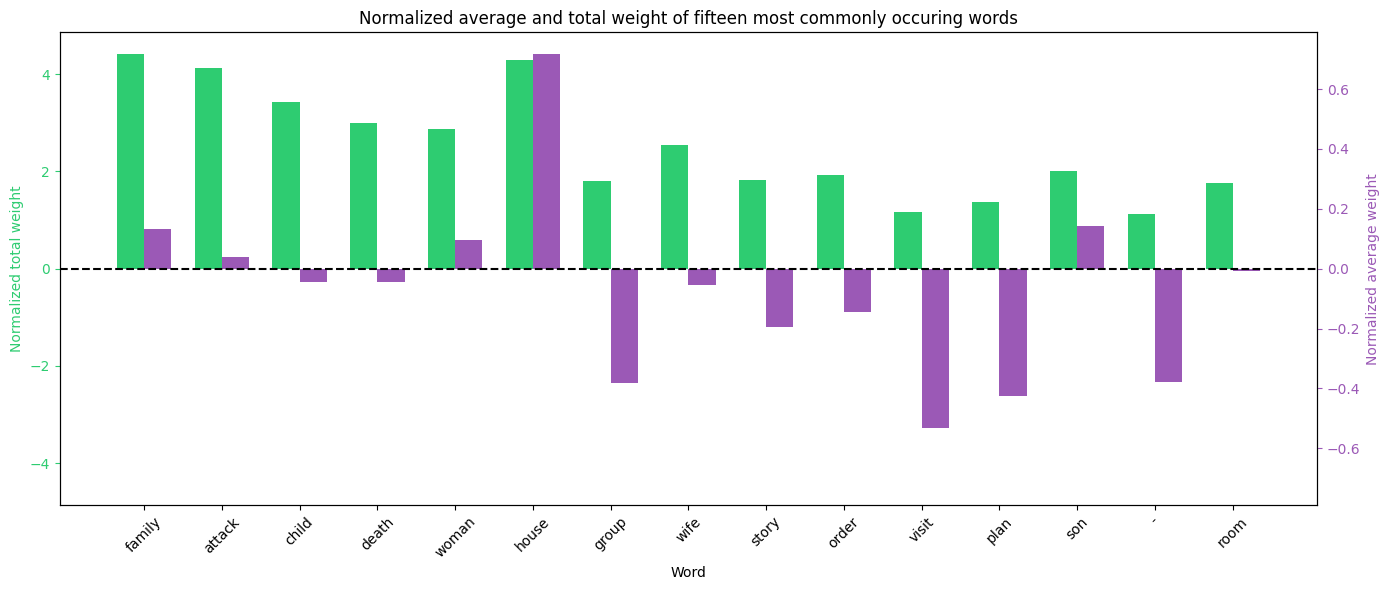

In [93]:
top_20_cnt = wts.sort_values(by='occ',  ascending=False).head(15)
plt.figure()
plot_n_sum_avg(top_20_cnt, 'Normalized average and total weight of fifteen most commonly occuring words')

Do it for the least commonly occuring ones:

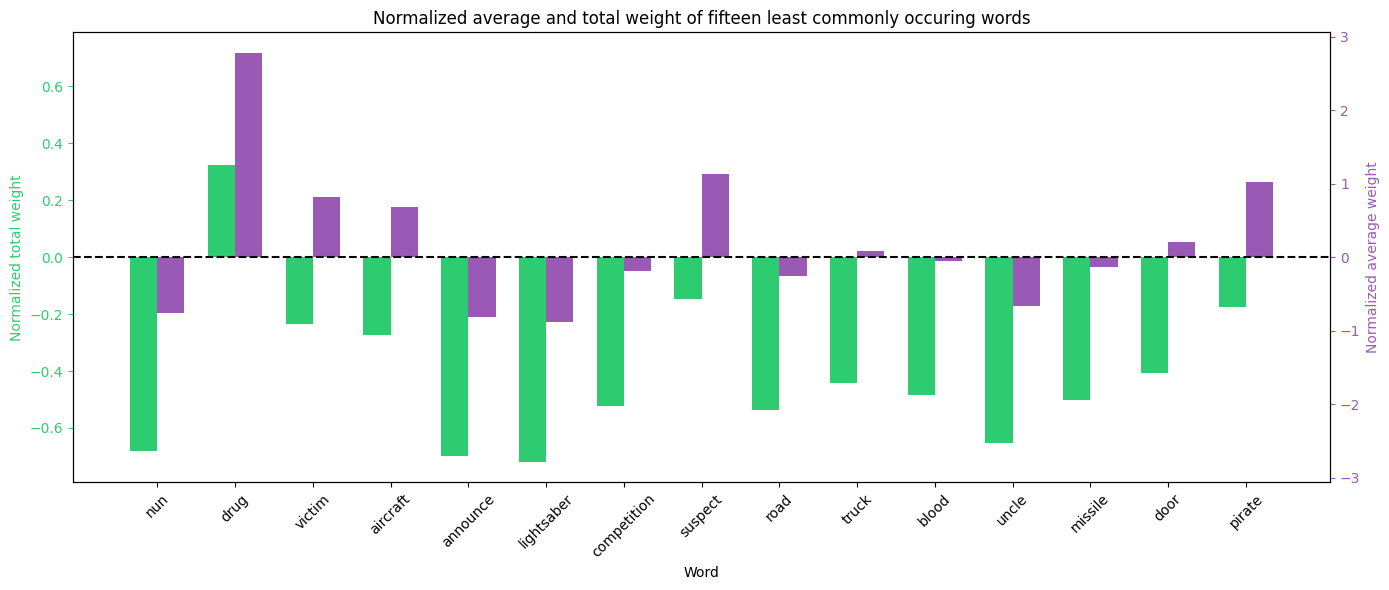

In [94]:
bottom_20_cnt = wts.sort_values(by='occ', ascending=True).head(15)
plot_n_sum_avg(bottom_20_cnt, 'Normalized average and total weight of fifteen least commonly occuring words')

We see that there are some words that have a high average weight with low total weight and vice versa. If the average weight is high and the total is low, it means that those words are very important to a small number of topics. The inverse situation means that the words appear often, but carry little importance to the topics they appear in. Let's check which words are the most specific to their respective topics.

Transform the data from the lda model into a list of (topic_id, word, weight) triplets:

In [95]:
most_important_words = []
for topic_num, topic_words in ldamodel.show_topics(num_topics=ldamodel.num_topics, num_words=20, formatted=False):
    for word, score in topic_words:
        most_important_words.append([topic_num, word, score])

If we divide each weight with the sum of weights, we should get info about how specific is the word to a certain topic. If the word appears in many topics, this ratio should tend to be small. Furthermore, if the word is equally important to many topics, this should push the ratio further down. On the other hand, if the ratio is 1, that means the word appears only in one topic.

In [96]:
for i, word in enumerate(most_important_words):
    most_important_words[i][2] = most_important_words[i][2] / wts.loc[word[1], 'sum']

In [97]:
sorted(most_important_words, key=lambda x: x[2], reverse=True)[:15]

[[0, 'choir', 1.0],
 [0, 'nun', 1.0],
 [0, 'announce', 1.0],
 [0, 'business', 1.0],
 [1, 'chicken', 1.0],
 [1, 'scent', 1.0],
 [1, 'perfume', 1.0],
 [1, 'card', 1.0],
 [1, 'bottle', 1.0],
 [1, 'method', 1.0],
 [1, 'whisky', 1.0],
 [1, 'mannequin', 1.0],
 [1, 'malt', 1.0],
 [1, 'pyramid', 1.0],
 [1, 'soon', 1.0]]

These observations can aid in interpretation of the topics.

## Explore topics and genres

Here we explore the relationship of topics in the film to its box-office revenue.

In [98]:
from tqdm import tqdm

In [99]:
num_topics = topic_names.shape[0]

Let's calculate topic distribution for each movie summary:

In [100]:
movie_topics = []
for index, row in tqdm(summary_df.iterrows()):
    topic_array = np.zeros(num_topics)
    # Using movie's entry from all_words list seems to give the most meaningful results
    bow = dictionary.doc2bow(all_words[str(row['MovieID'])])

    topic_list = ldamodel.get_document_topics(bow)
    for topic_id, topic_w in topic_list:
        topic_array[topic_id] = topic_w
    movie_topics.append(topic_array)    

303it [00:00, 1009.11it/s]

7588it [00:06, 1198.52it/s]


Let's create a DataFrame to keep the topics.

In [101]:
topic_df = pd.DataFrame(movie_topics, columns=topic_names['TopicDesc'].values)

Often, we will only need an indicator of whether a topic is prevalent in the movie. Here we binarize the coefficients.

In [102]:
binary_topic_df = topic_df.copy()
binary_topic_df = topic_df > 0

### MACROANALYSIS

To explore topic prevalences, we just need a proportion of movies that have a certain topic in them.

In [103]:
topic_prevalences = binary_topic_df.mean(axis=0).sort_values(ascending=False)*100

In [104]:
fig = px.bar(x=topic_prevalences.index, y=topic_prevalences, log_y=True, title='Proportion of movies containing each topic')
fig.update_layout(yaxis_title='Proportion of movies with a given topic')
#fig.write_html('lda_figs/proportion_all.html')
fig.show()

The most common topic seems to have to do with family and relationships. Second most common - crime.

Now let's explore the revenue.

First, construct a unified DataFrame to keep both info about movie revenue and its topics:

In [105]:
movie_topics_df = pd.concat([summary_df, topic_df], axis=1).reset_index(drop=True)

And then calculate per-topic mean revenue:

In [106]:
per_topic_means = []
for topic in topic_names['TopicDesc'].values:
    per_topic_means.append(movie_topics_df[movie_topics_df[topic]>0]['Inflation-adjusted box office revenue'].median())
per_topic_means = pd.Series(per_topic_means, index=topic_names['TopicDesc'].values).sort_values(ascending=False)

In [107]:
fig = px.bar(x=per_topic_means.index, y=per_topic_means, log_y=True)
fig.update_layout(yaxis_title='Mean revenue')
#fig.write_html('lda_figs/revenue_all.html')
fig.show()

Highest grossing topic might have to do with Sci-Fi spaceships, and the second highest grossing is heroism.

Let's use linear regression to explore how individual topics correlate to box-office success.

In [108]:
wanted_columns = ['Inflation-adjusted box office revenue'] + list(topic_names['TopicDesc'])
topics_BO = movie_topics_df[wanted_columns].copy()
topics_BO['Inflation-adjusted box office revenue'] =\
    (topics_BO['Inflation-adjusted box office revenue'] - topics_BO['Inflation-adjusted box office revenue'].mean()) /\
        topics_BO['Inflation-adjusted box office revenue'].std()

In [109]:
formula = "Q('Inflation-adjusted box office revenue') ~ " + " + ".join("Q('" + str(topic_name) + "')" for topic_name in topic_names['TopicDesc'])
model = smf.ols(formula=formula, data=topics_BO)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        OLS Regression Results                                        
======================================================================================================
Dep. Variable:     Q('Inflation-adjusted box office revenue')   R-squared:                       0.052
Model:                                                    OLS   Adj. R-squared:                  0.048
Method:                                         Least Squares   F-statistic:                     13.64
Date:                                        Fri, 22 Dec 2023   Prob (F-statistic):           4.34e-66
Time:                                                20:14:15   Log-Likelihood:                -10390.
No. Observations:                                        7464   AIC:                         2.084e+04
Df Residuals:                                            7433   BIC:                         2.106e+04
Df Model:                                                  30                                         
Covariance Type:                                    nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.3562      0.169      2.113      0.035       0.026       0.687
Q('company-choir-daughter-force-plan')         -0.6742      0.279     -2.413      0.016      -1.222      -0.126
Q('chicken-scent-world-woman-group')           -0.8379      0.428     -1.957      0.050      -1.677       0.001
Q('party-luck-poacher-patient-band')           -0.4333      0.373     -1.162      0.245      -1.164       0.297
Q('apprentice-spider-die-death-master')        -0.1583      0.324     -0.488      0.625      -0.794       0.477
Q('murder-case-killer-police-evidence')        -0.6774      0.206     -3.290      0.001      -1.081      -0.274
Q('ship-crew-destroy-order-mission')            0.6433      0.200      3.212      0.001       0.251       1.036
Q('girl-band-woman-play-song')                 -0.6516      0.192     -3.400      0.001      -1.027      -0.276
Q('police-money-drug-shoot-car')               -0.4957      0.192     -2.581      0.010      -0.872      -0.119
Q('house-body-attack-shoot-head')              -0.2212      0.200     -1.107      0.268      -0.613       0.170
Q('parent-camp-woman-family-play')             -0.6502      0.275     -2.361      0.018      -1.190      -0.110
Q('mother-family-woman-child-relationship')    -0.4957      0.183     -2.705      0.007      -0.855      -0.137
Q('town-machine-child-world-murder')           -0.6173      0.224     -2.762      0.006      -1.055      -0.179
Q('train-letter-write-writer-death')           -0.7000      0.239     -2.924      0.003      -1.169      -0.231
Q('town-creature-infected-infect-alien')       -0.5756      0.260     -2.218      0.027      -1.084      -0.067
Q('son-family-daughter-mother-marry')          -0.4482      0.193     -2.322      0.020      -0.827      -0.070
Q('power-attack-human-save-use')                0.4733      0.203      2.326      0.020       0.074       0.872
Q('team-game-win-play-player')                 -0.5675      0.197     -2.873      0.004      -0.955      -0.180
Q('house-brother-mother-money-say')            -0.5425      0.197     -2.755      0.006      -0.929      -0.156
Q('play-woman-stage-dance-family')             -0.5641      0.194     -2.901      0.004      -0.945      -0.183
Q('election-campaign-story-police-town')       -0.7794      0.226     -3.448      0.001      -1.223      -0.336
Q('ship-crew-pirate-room-island')               0.2762      0.220      1.253      0.210      -0.156       0.708
Q('toy-child-story-

There are just a few topics with a positive coefficient, but $R^2$ score is low and $\sigma^2$ is big, so the result should be taken with a grain of salt.

### MICROANALYSIS

Create a new DataFrame containing just columns we need for analysis, and add to it `Period` column, which will be used to group films into three-year periods.

In [110]:
binary_topic_df = movie_topics_df[topic_names['TopicDesc'].values].copy()
binary_topic_df = binary_topic_df > 0
binary_topic_df['Movie release year'] = movie_topics_df['Movie release year']
binary_topic_df['Period'] = binary_topic_df['Movie release year'] // 3*3

Now let's calculate the proportion of films containing certain topics for each period:

In [111]:
topic_counts = binary_topic_df.groupby(['Period'])[topic_names['TopicDesc'].values].mean()*100

In [112]:
fig = go.Figure()
for topic in topic_prevalences.index[:10]:
    fig.add_trace(go.Scatter(
        x=topic_counts.index,
        y=topic_counts[topic],
        hoverinfo='x+y',
        mode='lines',
        line_shape='spline',
        name=topic,
        #stackgroup='one'
    ))

fig.update_layout(
    title='Top 5 movie topics distribution over time',
    showlegend=True,
    xaxis=dict(
        title='Years',
        type='linear'
    ),
    yaxis=dict(
        title='Topic occurence (percentage)',
        type='linear',
        #range=[1, 100],
        ticksuffix='%'
    )
)

#fig.write_html('lda_figs/micro_occurence.html')

fig.show()

There were a lot of films about girls in bands playing songs pre-1900! But apart from that noise, it seems that lately the most popular films contain motives about families or school, while the crime has dropped to the third place.

Let's see how the box office compares. Here we caculate mean revenue for each topic per three-year period.

In [113]:
binary_topic_df['Money'] = movie_topics_df['Inflation-adjusted box office revenue']
#binary_topic_df['Money'] = movie_topics_df['Movie box office revenue']
per_topic_means = pd.DataFrame()
for topic in topic_names['TopicDesc'].values:
    per_topic_means[topic] = binary_topic_df[binary_topic_df[topic]].groupby('Period')['Money'].mean()
per_topic_means[per_topic_means.isna()] = 0

In [114]:
highest_grossing_topics = per_topic_means.sum(axis=0).sort_values(ascending=False).index[:10]

fig = go.Figure()
for topic in highest_grossing_topics:
    fig.add_trace(go.Scatter(
        x=per_topic_means.index,
        y=per_topic_means[topic],
        hoverinfo='x+y',
        mode='lines',
        line_shape='spline',
        name=topic,
        #stackgroup='one'
    ))

fig.update_layout(
    title='Per-topic mean movie revenue, zoomed in',
    showlegend=True,
    xaxis=dict(
        title='Years',
        type='linear'
    ),
    yaxis=dict(
        title='Box-office revenue',
        type='linear',
    )
)

#fig.write_html('lda_figs/micro_revenue_zoomed.html')

fig.show()

Pre-1940 data seems to be heavily influenced by _Gone with the Wind_, the highest grossing movie of all time (when adjusted for inflation). 1941 seems to be a good year to make a war propaganda piece, and the bump around 1971 might be attributed to _The Godfather_ or _Diamonds are Forever_.

But let's also see what did the highest-grossing film make in each period. Instead of calculating means, let's look at the `max` value.

In [115]:
binary_topic_df['Money'] = movie_topics_df['Inflation-adjusted box office revenue']
#binary_topic_df['Money'] = movie_topics_df['Movie box office revenue']
per_topic_max = pd.DataFrame()
for topic in topic_names['TopicDesc'].values:
    per_topic_max[topic] = binary_topic_df[binary_topic_df[topic]].groupby('Period')['Money'].max()
per_topic_max[per_topic_means.isna()] = 0

In [116]:
highest_grossing_topics = per_topic_max.sum(axis=0).sort_values(ascending=False).index[:10]

fig = go.Figure()
for topic in highest_grossing_topics:
    fig.add_trace(go.Scatter(
        x=per_topic_max.index,
        y=per_topic_max[topic],
        hoverinfo='x+y',
        mode='lines',
        line_shape='spline',
        name=topic
    ))

fig.update_layout(
    title='Per-topic max movie revenue',
    showlegend=True,
    xaxis=dict(
        title='Years',
        type='linear'
    ),
    yaxis=dict(
        title='Box-office revenue',
        type='linear',
    )
)

#fig.write_html('lda_figs/micro_max_revenue.html')

fig.show()

Here, we can clearly see the bumps that James Cameron made (1997 with _Titanic_ and 2009 with _Avatar_).

Finally, some of these results seem strange. For example, how is it possible that on average, movies made more money in 1900s than today? Is the cinema dying? Take a look at the number of moviesmade per three-year period.

In [117]:
number_of_movies_per_period = binary_topic_df.groupby('Period')['Money'].count()

fig = px.bar(x=number_of_movies_per_period.index, y=number_of_movies_per_period)
fig.update_layout(yaxis_title='Mean revenue')
fig.show()

It is clearly visible that many more films are made today than even just 50 years ago. So if you were to venture to the world of filmmaking, the period with the least competition would be about a 100 years ago, which explains why the average revenue was so high!